In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os,re,copy
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (30,10)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'y'

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,OrdinalEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier,KerasRegressor

import eli5
from eli5.sklearn import PermutationImportance

import kerastuner as kt

In [2]:
print(tf.__version__)

2.8.0


In [3]:
from tensorflow.keras.datasets import boston_housing as boston
boston_housing = boston.load_data(path='boston_housing.npz', test_split=0.2, seed=409)
feature_names = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']

# let's go for 60% train, 20% validation, and keep our 20% test
(x_train, y_train), (x_test, y_test) = boston_housing
train_data = pd.DataFrame(np.concatenate((x_train,np.expand_dims(y_train,1)),axis=1),columns=feature_names)
test_data = pd.DataFrame(np.concatenate((x_test,np.expand_dims(y_test,1)),axis=1),columns=feature_names)

x_train = train_data.sample(frac=1).reset_index(drop=True)
x_val = train_data.iloc[-len(test_data):,:].reset_index(drop=True)
x_train = train_data.iloc[:-len(test_data),:].reset_index(drop=True)
x_test = test_data.sample(frac=1).reset_index(drop=True)
y_train = x_train.pop('MEDV')
y_val = x_val.pop('MEDV')
y_test = x_test.pop('MEDV')

#### **FIRST EXAMPLE - UN-NORMALIZED**

In [ ]:
EPOCHS = 2000

tf.random.set_seed(10)

boston_model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)
])

boston_model_1.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mae'])

boston_hist_1 = boston_model_1.fit(x_train, y_train, epochs=EPOCHS, verbose=0, validation_data=(x_val,y_val)) 

In [512]:
boston_model_1.save('boston_model_1')

INFO:tensorflow:Assets written to: boston_model_1/assets


In [513]:
boston_hist_1 = pd.DataFrame(boston_hist_1.history)

In [514]:
boston_hist_1['loss_diffs'] = boston_hist_1.apply(lambda x: np.abs(100*(x['val_loss']-x['loss'])/x['loss']),axis=1)
boston_hist_1['mae_diffs'] = boston_hist_1.apply(lambda x: np.abs(100*(x['val_mae']-x['mae'])/x['mae']),axis=1)

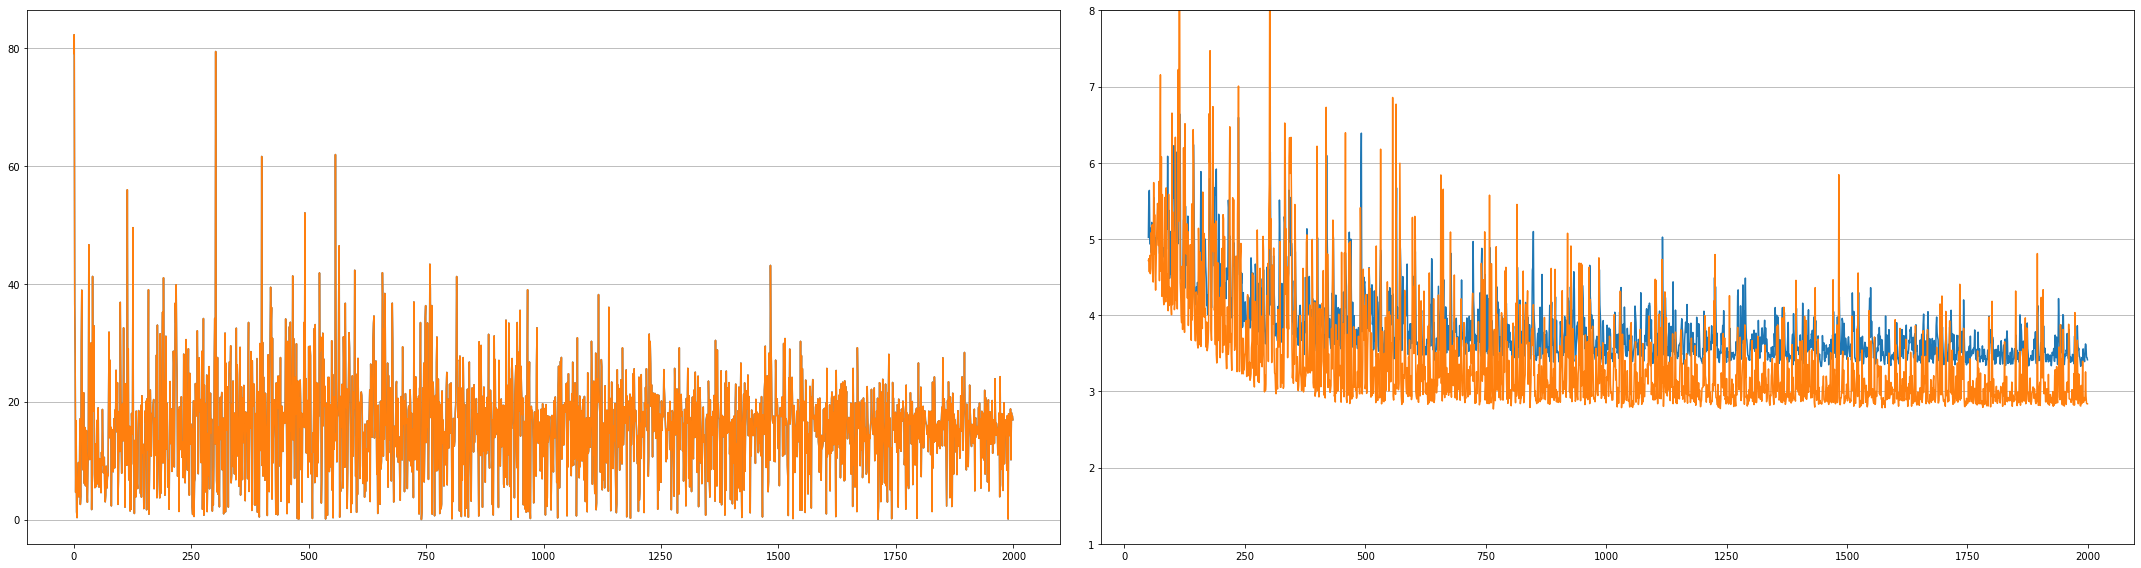

In [515]:
fig,axes = plt.subplots(1,2,figsize=(30,8))
fig.tight_layout()
axes[0].plot(boston_hist_1[['loss_diffs','mae_diffs']]);
axes[1].set_ylim([1,8])
axes[1].plot(boston_hist_1[['mae','val_mae']][50:]);

In [ ]:
boston_preds_1 = boston_model_1.predict(x_test)

  MAE is 3.2337658405303955


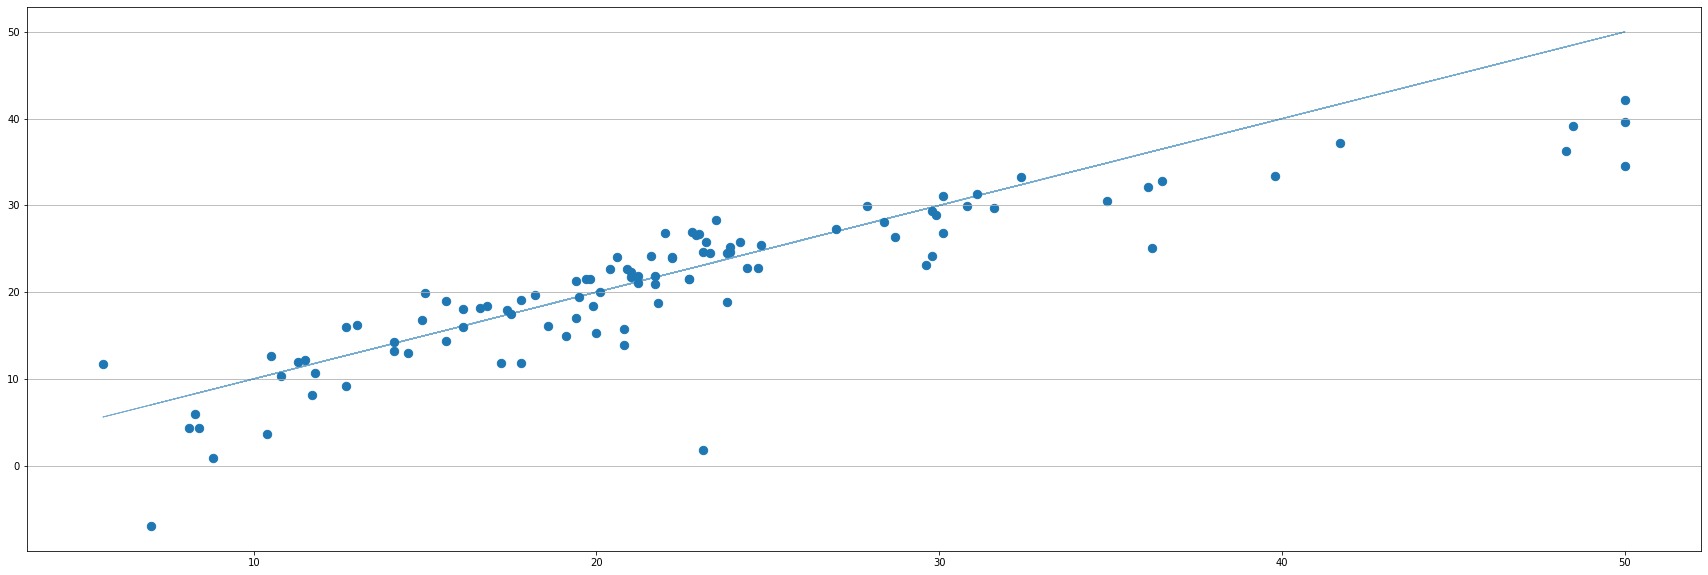

In [518]:
plt.plot(y_test,y_test,lw=0.9,alpha=0.6)
plt.scatter(y_test,boston_preds_1,s=70)
print(f'  MAE is {np.mean([np.abs(a-b) for a,b in zip(y_test,boston_preds_1)])}')

#### **0-1 NORMALIZE THE DATA USING MIN-MAX SCALER**

In [519]:
ct = make_column_transformer(
    (MinMaxScaler(),feature_names[:-1])
)
ct.fit(x_train)

x_train_normal = ct.transform(x_train)
x_val_normal = ct.transform(x_val)
x_test_normal = ct.transform(x_test)

In [ ]:
EPOCHS = 2000

tf.random.set_seed(10)

boston_model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)
])

boston_model_2.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mae'])

boston_hist_2 = boston_model_2.fit(x_train_normal, y_train, epochs=EPOCHS, verbose=0, validation_data=(x_val_normal,y_val)) 

In [521]:
boston_model_2.save('boston_model_2')

INFO:tensorflow:Assets written to: boston_model_2/assets


In [522]:
boston_hist_2 = pd.DataFrame(boston_hist_2.history)

In [523]:
boston_hist_2['loss_diffs'] = boston_hist_2.apply(lambda x: np.abs(100*(x['val_loss']-x['loss'])/x['loss']),axis=1)
boston_hist_2['mae_diffs'] = boston_hist_2.apply(lambda x: np.abs(100*(x['val_mae']-x['mae'])/x['mae']),axis=1)

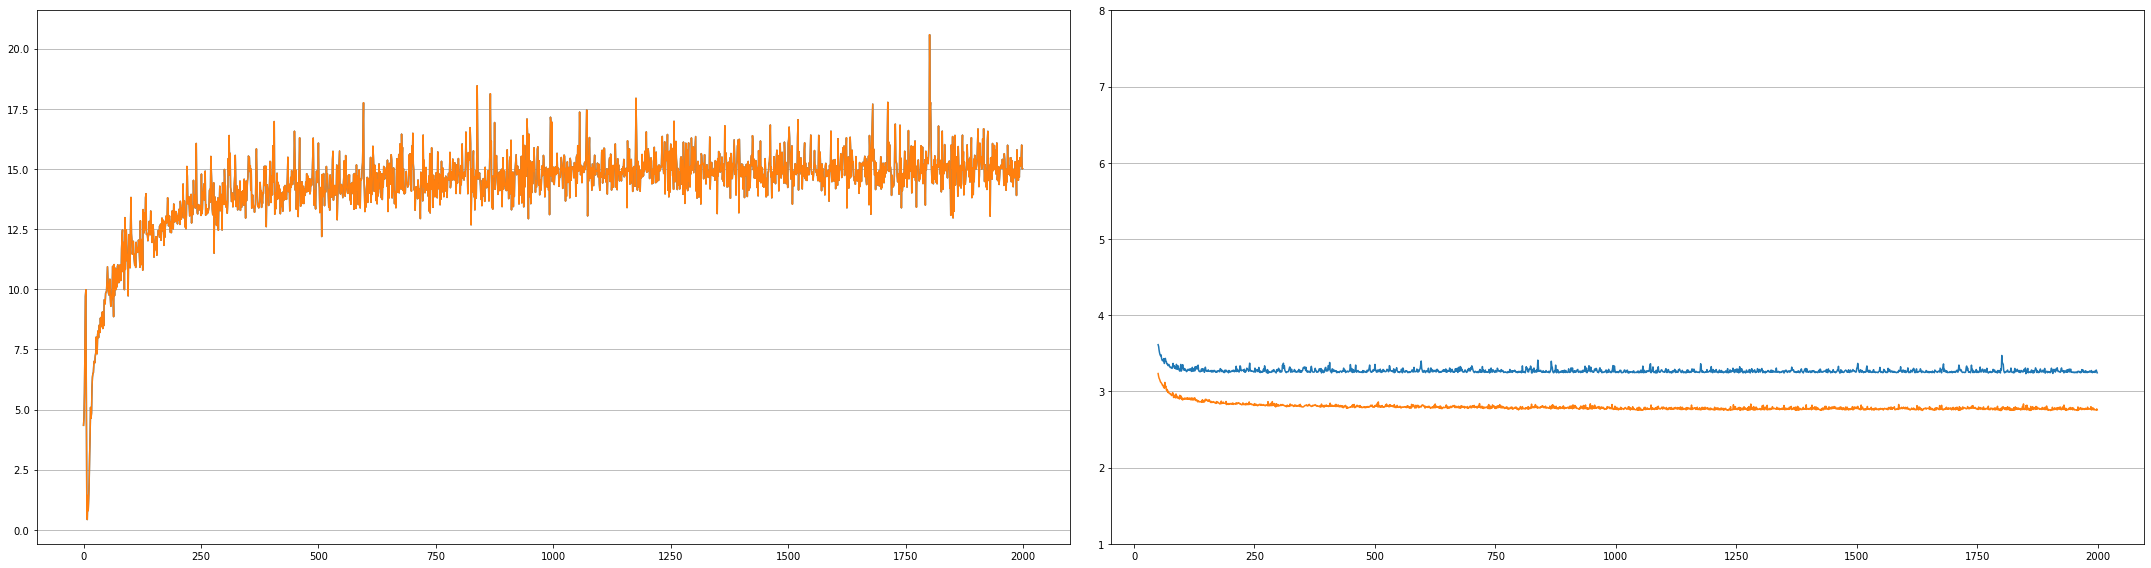

In [524]:
fig,axes = plt.subplots(1,2,figsize=(30,8))
fig.tight_layout()
axes[0].plot(boston_hist_2[['loss_diffs','mae_diffs']]);
axes[1].set_ylim([1,8])
axes[1].plot(boston_hist_2[['mae','val_mae']][50:]);

In [ ]:
boston_preds_2 = boston_model_2.predict(x_test_normal)

  MAE is 3.0447490215301514


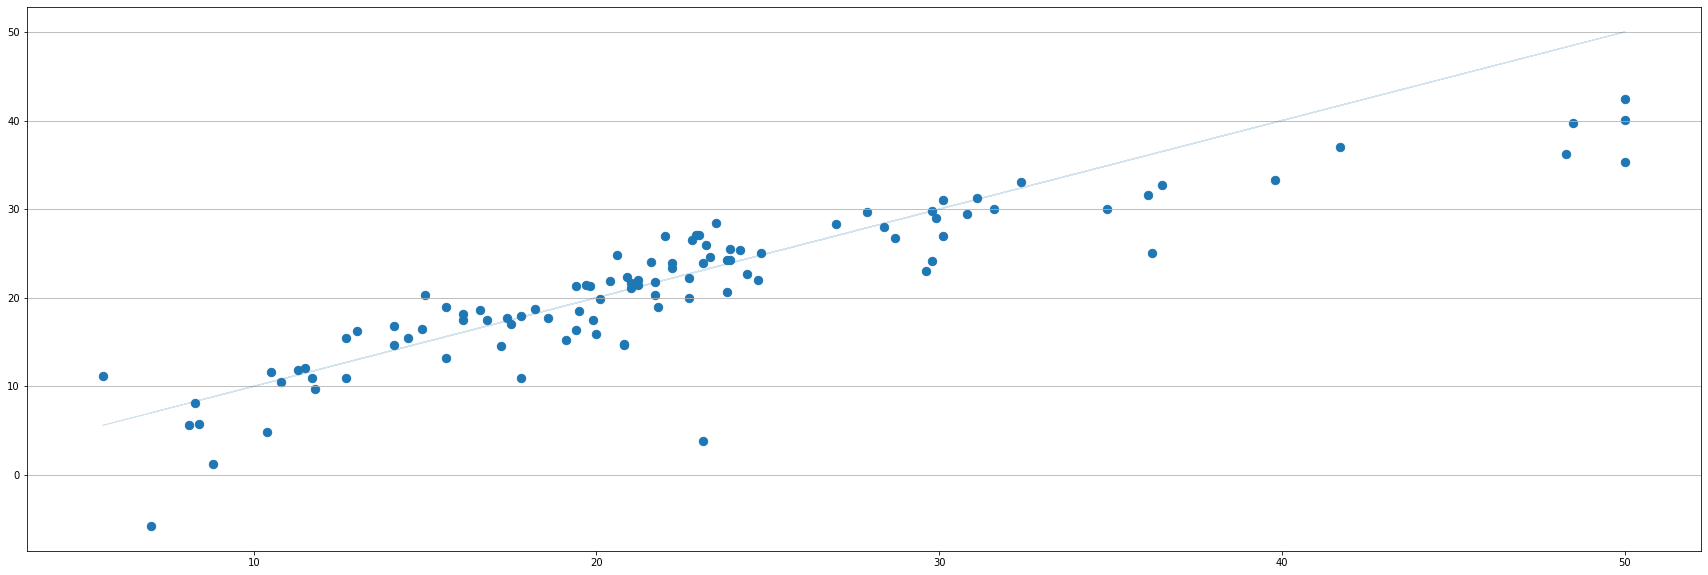

In [526]:
plt.plot(y_test,y_test,lw=0.9,alpha=0.2)
plt.scatter(y_test,boston_preds_2,s=70)
print(f'  MAE is {np.mean([np.abs(a-b) for a,b in zip(y_test,boston_preds_2)])}')

#### **STANDARDIZE THE DATA BY ITS MEAN AND VARIANCE BEFORE NORNALIZING**

In [4]:
def norm(x,y=None):
    if y is None: y=x
    train_stats = pd.DataFrame(y).describe().transpose()
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(pd.DataFrame(x_train))
normed_val_data = norm(pd.DataFrame(x_val),pd.DataFrame(x_train))
normed_test_data = norm(pd.DataFrame(x_test),pd.DataFrame(x_train))

In [65]:
normed_train_data.to_csv('data/normed_train_data.csv',index=False)
normed_val_data.to_csv('data/normed_val_data.csv',index=False)
normed_test_data.to_csv('data/normed_test_data.csv',index=False)
y_train.to_csv('data/y_train.csv',index=False)
y_val.to_csv('data/y_val.csv',index=False)
y_test.to_csv('data/y_test.csv',index=False)

In [ ]:
EPOCHS = 2000

tf.random.set_seed(10)

boston_model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)
])

boston_model_3.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mae'])

boston_history_3=boston_model_3.fit(normed_train_data,y_train, epochs=EPOCHS, verbose=0, validation_data=(normed_val_data,y_val))

In [529]:
boston_model_3.save('boston_model_3')

INFO:tensorflow:Assets written to: boston_model_3/assets


In [530]:
boston_history_3 = pd.DataFrame(boston_history_3.history)

In [531]:
boston_history_3['loss_diffs'] = boston_history_3.apply(lambda x: np.abs(100*(x['val_loss']-x['loss'])/x['loss']),axis=1)
boston_history_3['mae_diffs'] = boston_history_3.apply(lambda x: np.abs(100*(x['val_mae']-x['mae'])/x['mae']),axis=1)

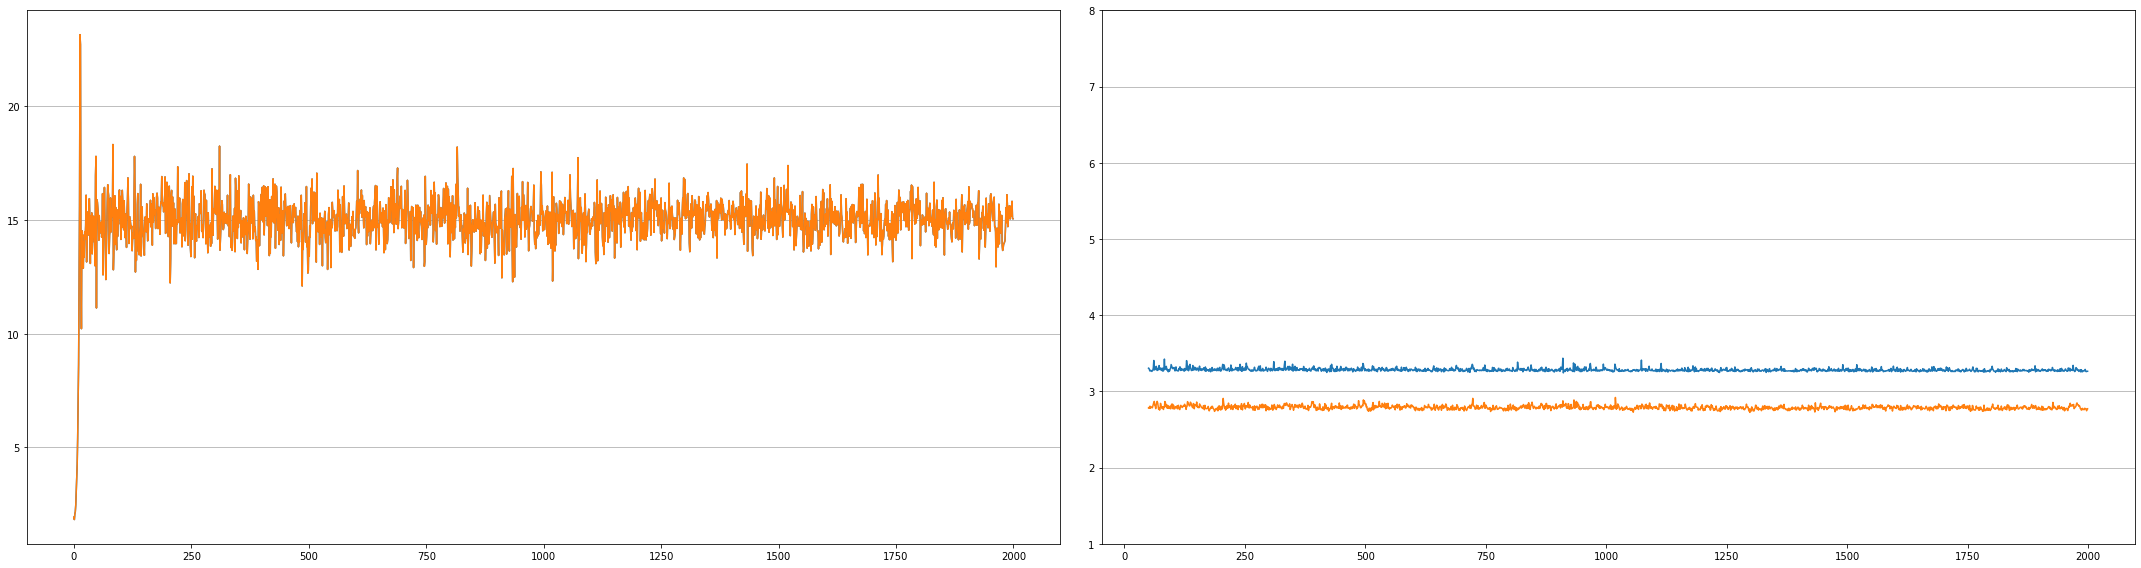

In [532]:
fig,axes = plt.subplots(1,2,figsize=(30,8))
fig.tight_layout()
axes[0].plot(boston_history_3[['loss_diffs','mae_diffs']]);
axes[1].set_ylim([1,8])
axes[1].plot(boston_history_3[['mae','val_mae']][50:]);

In [ ]:
boston_preds_3 = boston_model_3.predict(normed_test_data)

  MAE is 3.018671989440918


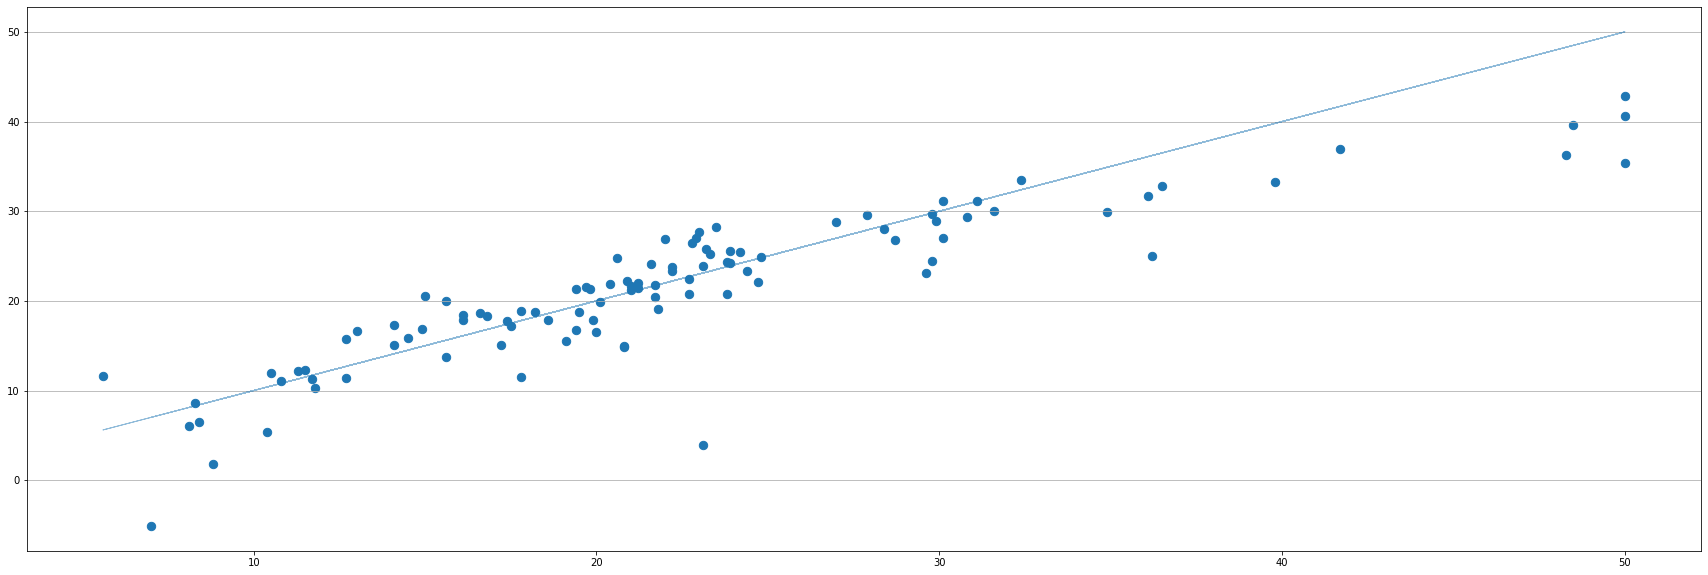

In [534]:
plt.plot(y_test,y_test,lw=0.9,alpha=0.5)
plt.scatter(y_test,boston_preds_3,s=70)
print(f'  MAE is {np.mean([np.abs(a-b) for a,b in zip(y_test,boston_preds_3)])}')

#### **LET'S TRY SOME NEW LAYERS, MORE NEURONS AND USE REGULARIZATION**

In [ ]:
EPOCHS = 2000

tf.random.set_seed(10)

boston_model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(400),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(40),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(4),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])

boston_model_4.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mae'])

boston_history_4 = boston_model_4.fit(normed_train_data,y_train, epochs=EPOCHS, verbose=0, validation_data=(normed_val_data,y_val))

In [536]:
boston_model_4.save('boston_model_4')

INFO:tensorflow:Assets written to: boston_model_4/assets


In [537]:
boston_history_4 = pd.DataFrame(boston_history_4.history)

In [538]:
boston_history_4['loss_diffs'] = boston_history_4.apply(lambda x: np.abs(100*(x['val_loss']-x['loss'])/x['loss']),axis=1)
boston_history_4['mae_diffs'] = boston_history_4.apply(lambda x: np.abs(100*(x['val_mae']-x['mae'])/x['mae']),axis=1)

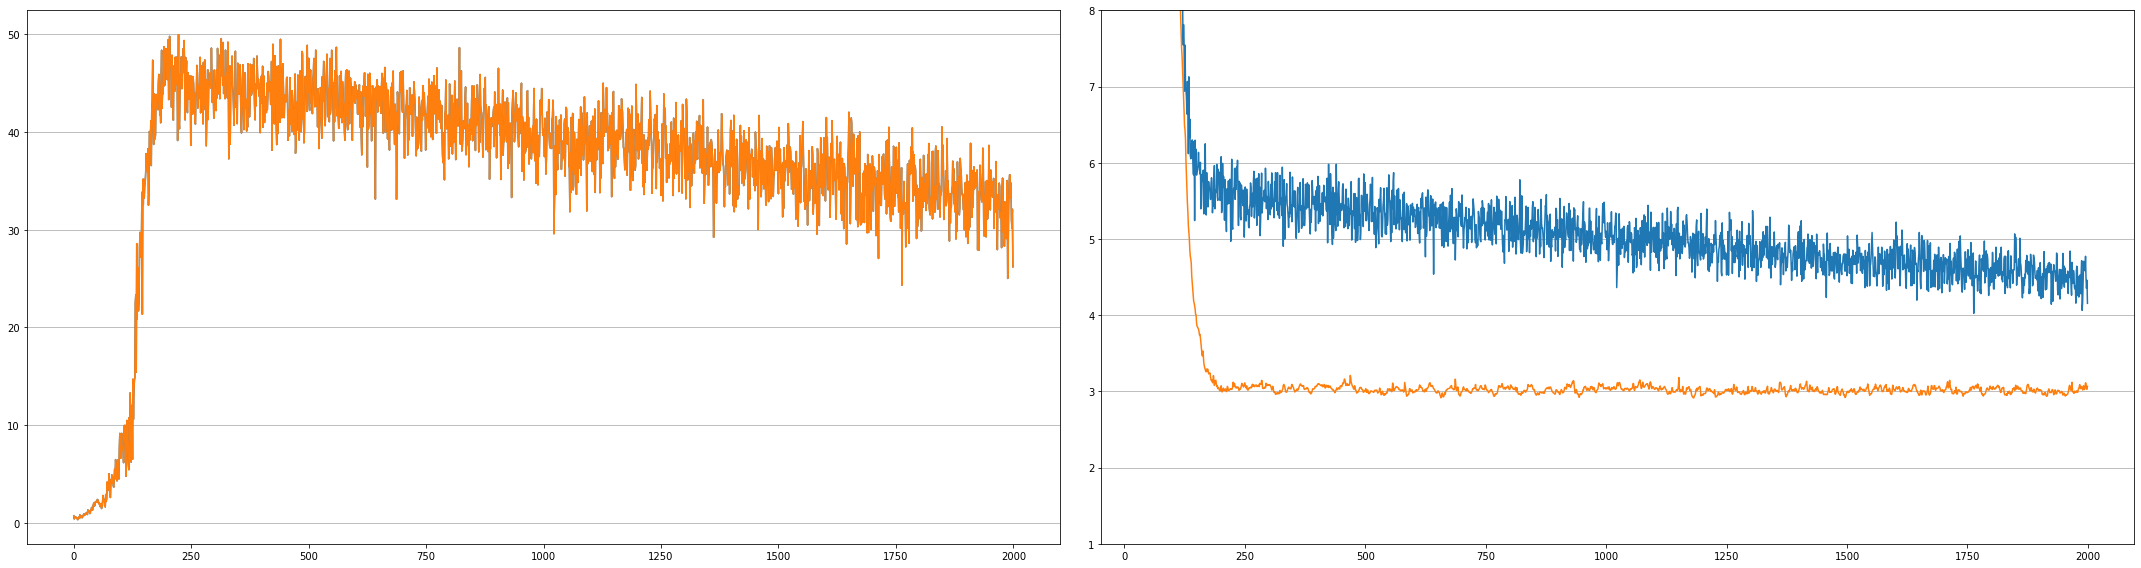

In [539]:
fig,axes = plt.subplots(1,2,figsize=(30,8))
fig.tight_layout()
axes[0].plot(boston_history_4[['loss_diffs','mae_diffs']]);
axes[1].set_ylim([1,8])
axes[1].plot(boston_history_4[['mae','val_mae']][50:]);

In [ ]:
boston_preds_4 = boston_model_4.predict(normed_test_data)

  MAE is 3.2076992988586426


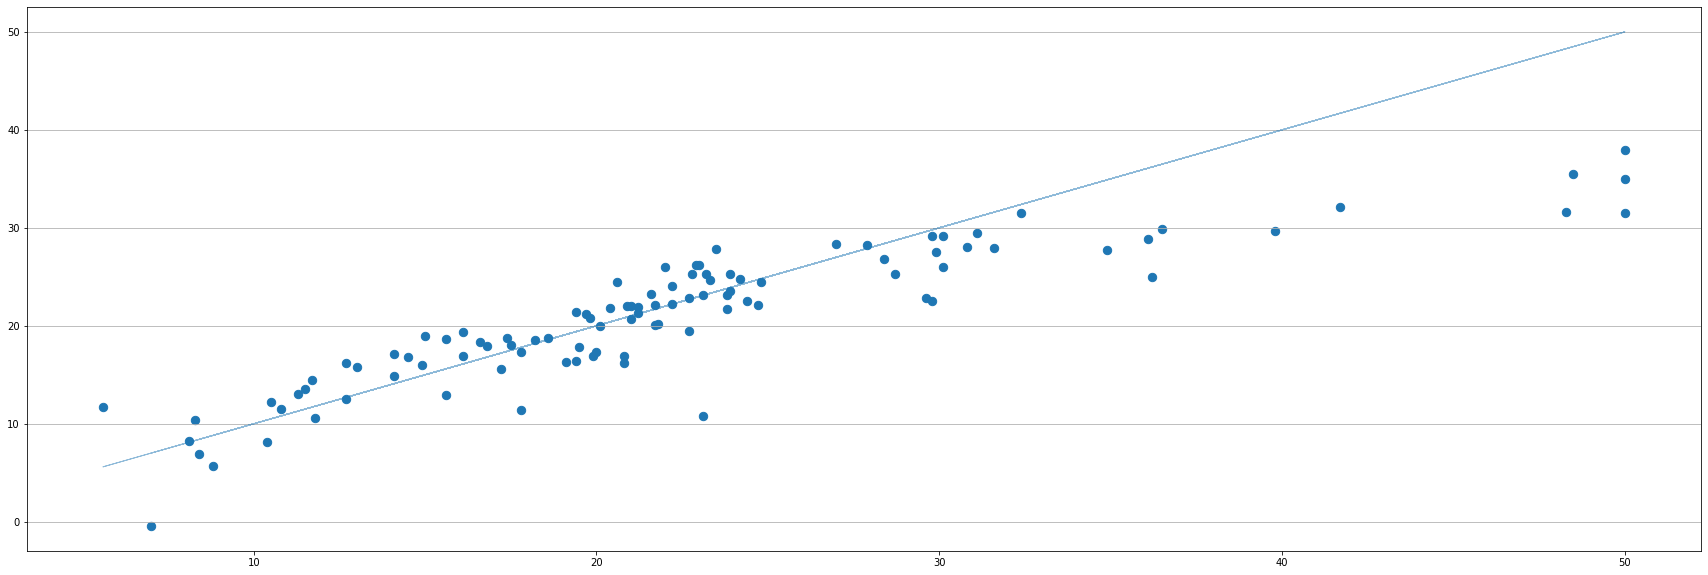

In [541]:
plt.plot(y_test,y_test,lw=0.9,alpha=0.5)
plt.scatter(y_test,boston_preds_4,s=70)
print(f'  MAE is {np.mean([np.abs(a-b) for a,b in zip(y_test,boston_preds_4)])}')

#### **REMOVE SUCCESSIVE FEATURES AS IMPORTANCE HEURISTIC**

In [ ]:
EPOCHS = 500

model_list = []

for i,j in enumerate(x_train.columns):
    normed_train_new = np.delete(np.array(normed_train_data), i, 1)
    normed_val_new = np.delete(np.array(normed_val_data), i, 1)
    normed_test_new = np.delete(np.array(normed_test_data), i, 1)

    tf.random.set_seed(10)

    boston_model_5 = tf.keras.Sequential([
      tf.keras.layers.Dense(400),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(40),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(4),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1)
    ])

    boston_model_5.compile(loss=tf.keras.losses.mae,
                              optimizer=tf.keras.optimizers.Adam(),
                              metrics=['mae'])

    model_list.append(boston_model_5.fit(normed_train_new,y_train, epochs=500, verbose=0, validation_data=(normed_val_new,y_val)))
    boston_model_5.save(f'boston_model_5_{i}')

In [543]:
for i in range(len(model_list)):
    if i==0:
        model_list_df = pd.DataFrame(model_list[i].history)[['loss']]
    else:
        model_list_df = pd.concat([model_list_df,pd.DataFrame(model_list[i].history)[['loss']]],axis=1)
model_list_df.columns = feature_names[:-1]
model_list_df.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
495,5.503483,5.455077,5.449249,5.455500,5.513387,5.555981,5.441567,5.546933,5.438823,5.435957,5.510905,5.513594,5.614686
496,5.221859,5.178204,5.217250,5.174073,5.183259,5.477696,5.202306,5.151143,5.220348,5.239211,5.341294,5.262421,5.317333
497,5.862449,5.828732,5.809196,5.894849,5.898810,5.812608,5.828706,5.876507,5.877906,5.842088,5.914955,5.902771,6.047587
498,5.439791,5.403795,5.388159,5.378378,5.426015,5.596710,5.428222,5.448350,5.429535,5.422597,5.545658,5.470899,5.495458
499,5.440713,5.402047,5.369065,5.398235,5.424497,5.538260,5.388370,5.533339,5.437568,5.449764,5.449896,5.443717,5.579577


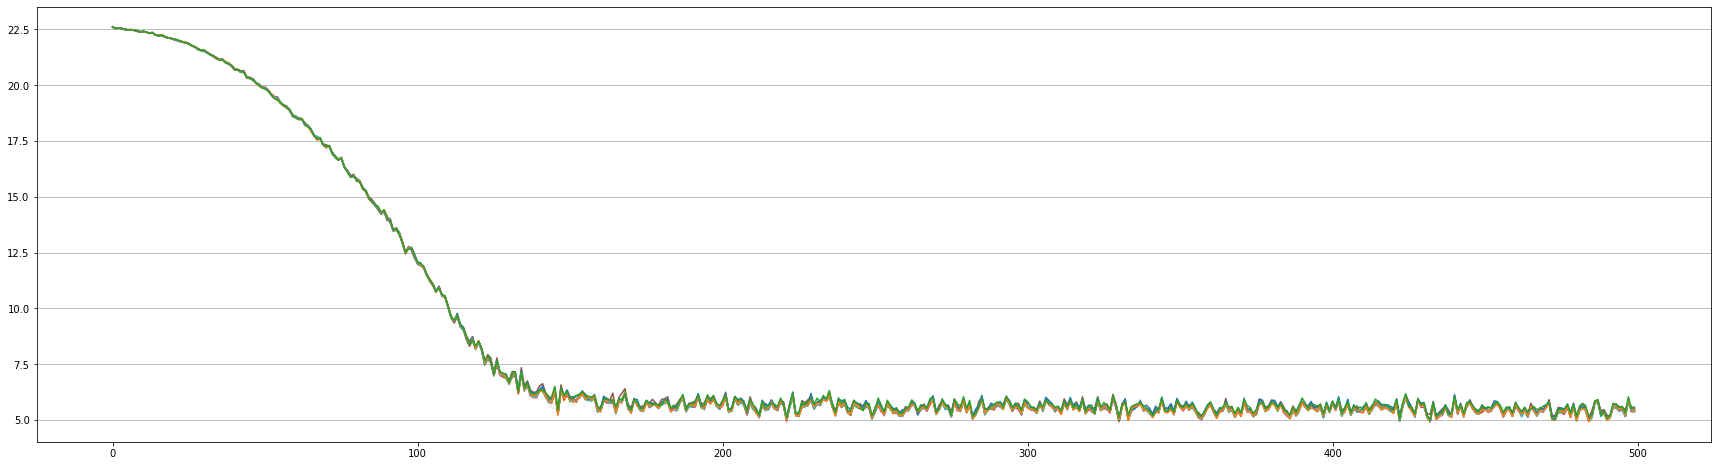

In [544]:
fig,axes = plt.subplots(1,1,figsize=(30,8))
axes.plot(model_list_df);

#### **DIFFERENT ACTIVATIONS, REGULARIZATIONS, MORE EPOCHS**

In [545]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='selu', input_shape=[13]),
        tf.keras.layers.Dense(64, activation='selu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(16,activation='sigmoid'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam()

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae','mse'])
    return model

In [ ]:
EPOCHS = 4000

boston_model_6 = build_model()

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-2 / 10**(epoch/EPOCHS)) 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000)

boston_history_6 = boston_model_6.fit(
    normed_train_data, y_train,
    epochs=EPOCHS, verbose=0, validation_data = (normed_val_data, y_val),
    callbacks=[lr_scheduler,early_stop])

In [547]:
boston_model_6.save('boston_model_6')

INFO:tensorflow:Assets written to: boston_model_6/assets


In [548]:
boston_history_6 = pd.DataFrame(boston_history_6.history)

In [549]:
boston_history_6['loss_diffs'] = boston_history_6.apply(lambda x: np.abs(100*(x['val_loss']-x['loss'])/x['loss']),axis=1)
boston_history_6['mae_diffs'] = boston_history_6.apply(lambda x: np.abs(100*(x['val_mae']-x['mae'])/x['mae']),axis=1)

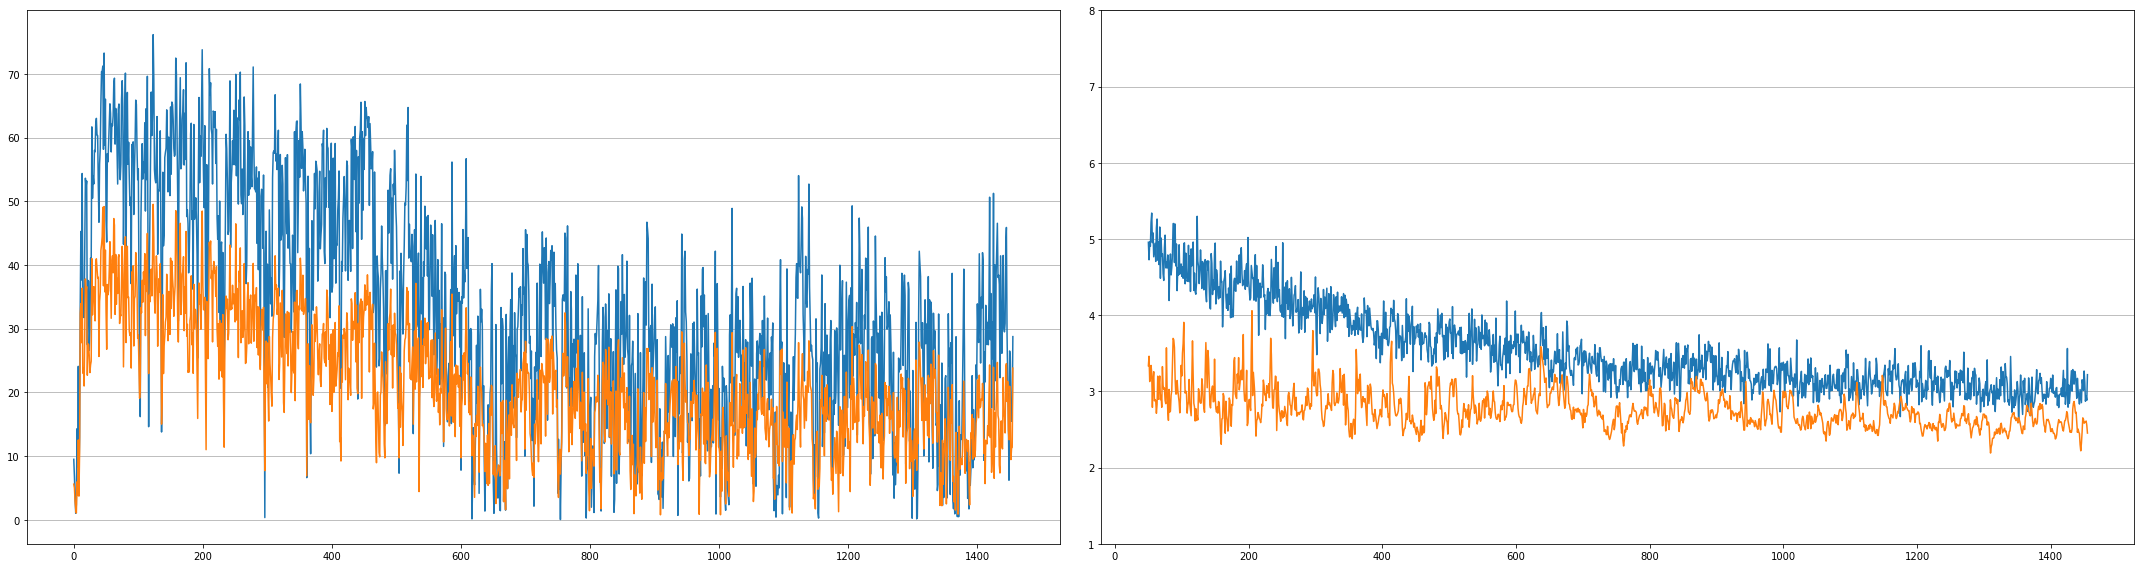

In [550]:
fig,axes = plt.subplots(1,2,figsize=(30,8))
fig.tight_layout()
axes[0].plot(boston_history_6[['loss_diffs','mae_diffs']]);
axes[1].set_ylim([1,8])
axes[1].plot(boston_history_6[['mae','val_mae']][50:]);

In [551]:
boston_preds_6 = boston_model_6.predict(normed_test_data)

2022-03-19 01:28:53.093105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  MAE is 2.667710781097412


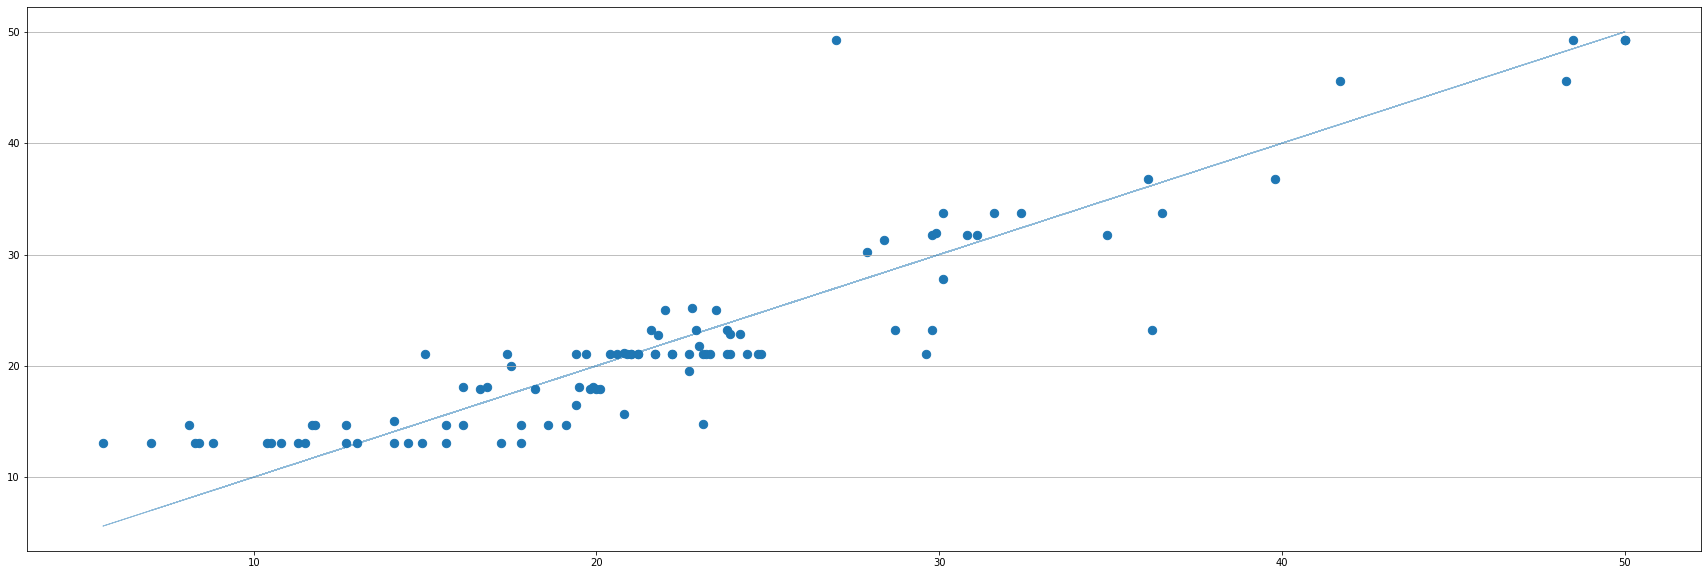

In [552]:
plt.plot(y_test,y_test,lw=0.9,alpha=0.5)
plt.scatter(y_test,boston_preds_6,s=70)
print(f'  MAE is {np.mean([np.abs(a-b) for a,b in zip(y_test,boston_preds_6)])}')

#### **USING KERAS TUNER TO OPTIMIZE HYPERPARAMETERS**

##### First Version

In [553]:
def model_builder_1(hp):
    model = tf.keras.Sequential()

    hp_units_1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    hp_units_2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    model.add(tf.keras.layers.Dense(units=hp_units_1, activation='selu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(units=hp_units_2, activation='selu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(1))

    r10 = 10**0.5
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, r10*1e-3, 1e-3, r10*1e-4, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=['mae','mse'])

    return model

In [554]:
tuner_1 = kt.Hyperband(model_builder_1,
                     objective='val_mse',
                     overwrite = True,
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [555]:
perf_log = []

class CatchLog(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        perf_log.append(logs)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True)

In [556]:
tuner_1.search(normed_train_data, y_train, epochs=80, validation_data=(normed_val_data,y_val), callbacks=[stop_early])

best_hps_1 = tuner_1.get_best_hyperparameters(num_trials=1)[0]

print(f"""The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps_1.get('units1')}, in the second layer it's {best_hps_1.get('units2')} and the optimal learning rate for the optimizer
is {best_hps_1.get('learning_rate')}.""")

Trial 254 Complete [00h 00m 31s]
val_mse: 398.5509033203125

Best val_mse So Far: 6.562104225158691
Total elapsed time: 01h 00m 02s
INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 416, in the second layer it's 288 and the optimal learning rate for the optimizer
is 0.0031622776601683794.


In [ ]:
EPOCHS = 1000

boston_model_7 = tuner.hypermodel.build(best_hps_1)
boston_history_7 = boston_model_7.fit(normed_train_data, y_train, epochs=EPOCHS,
                                      validation_data=(normed_val_data, y_val), verbose=0, callbacks=[PrintDot(),stop_early])
boston_model_7.save('boston_model_7')

In [558]:
boston_history_7 = pd.DataFrame(boston_history_7.history)

In [559]:
boston_history_7['loss_diffs'] = boston_history_7.apply(lambda x: np.abs(100*(x['val_loss']-x['loss'])/x['loss']),axis=1)
boston_history_7['mae_diffs'] = boston_history_7.apply(lambda x: np.abs(100*(x['val_mae']-x['mae'])/x['mae']),axis=1)

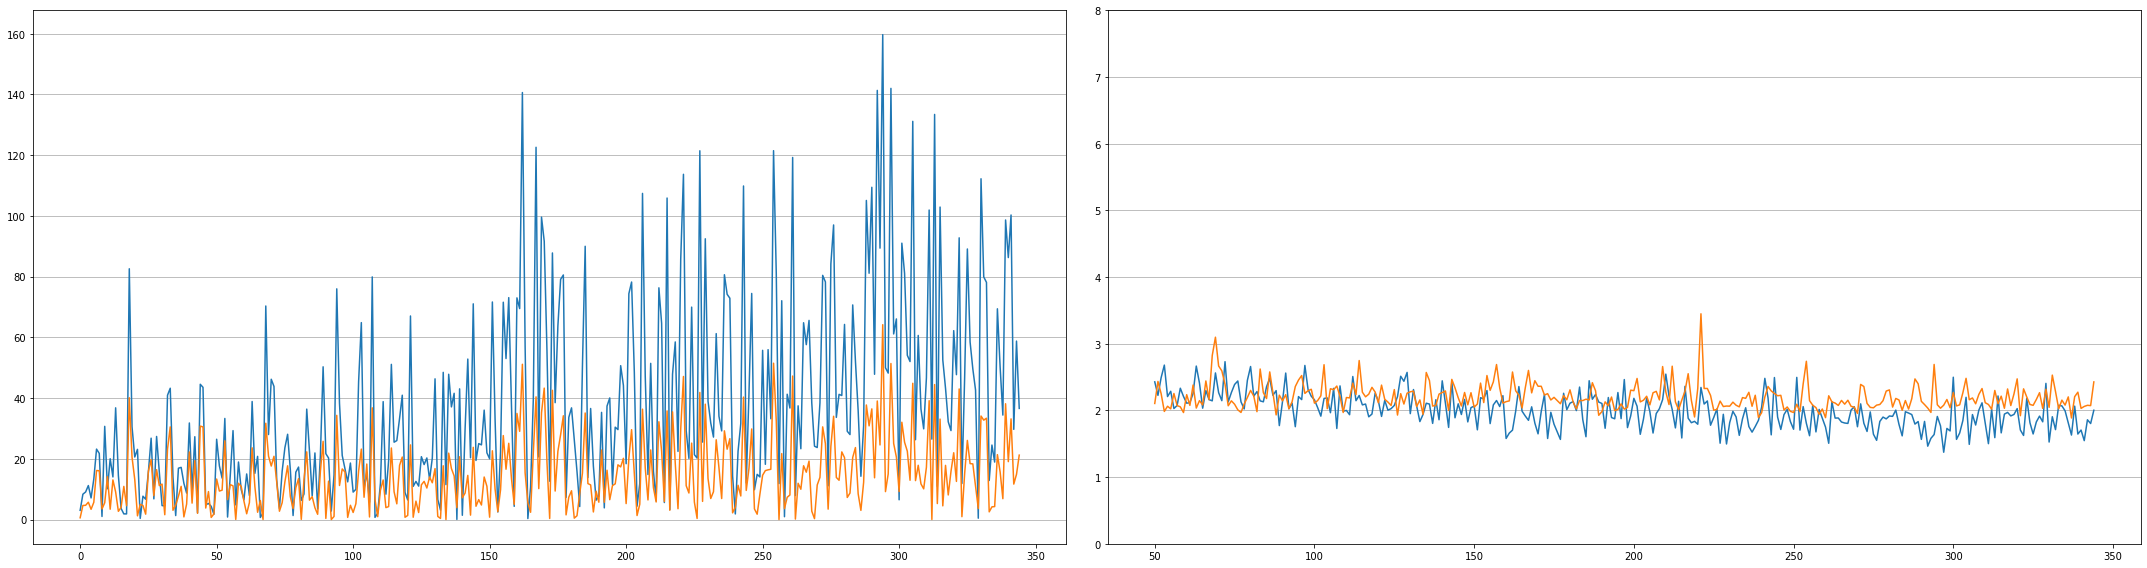

In [560]:
fig,axes = plt.subplots(1,2,figsize=(30,8))
fig.tight_layout()
axes[0].plot(boston_history_7[['loss_diffs','mae_diffs']]);
axes[1].set_ylim([0,8])
axes[1].plot(boston_history_7[['mae','val_mae']][50:]);

In [ ]:
boston_preds_7 = boston_model_7.predict(normed_test_data)

  MAE is 2.4063892364501953


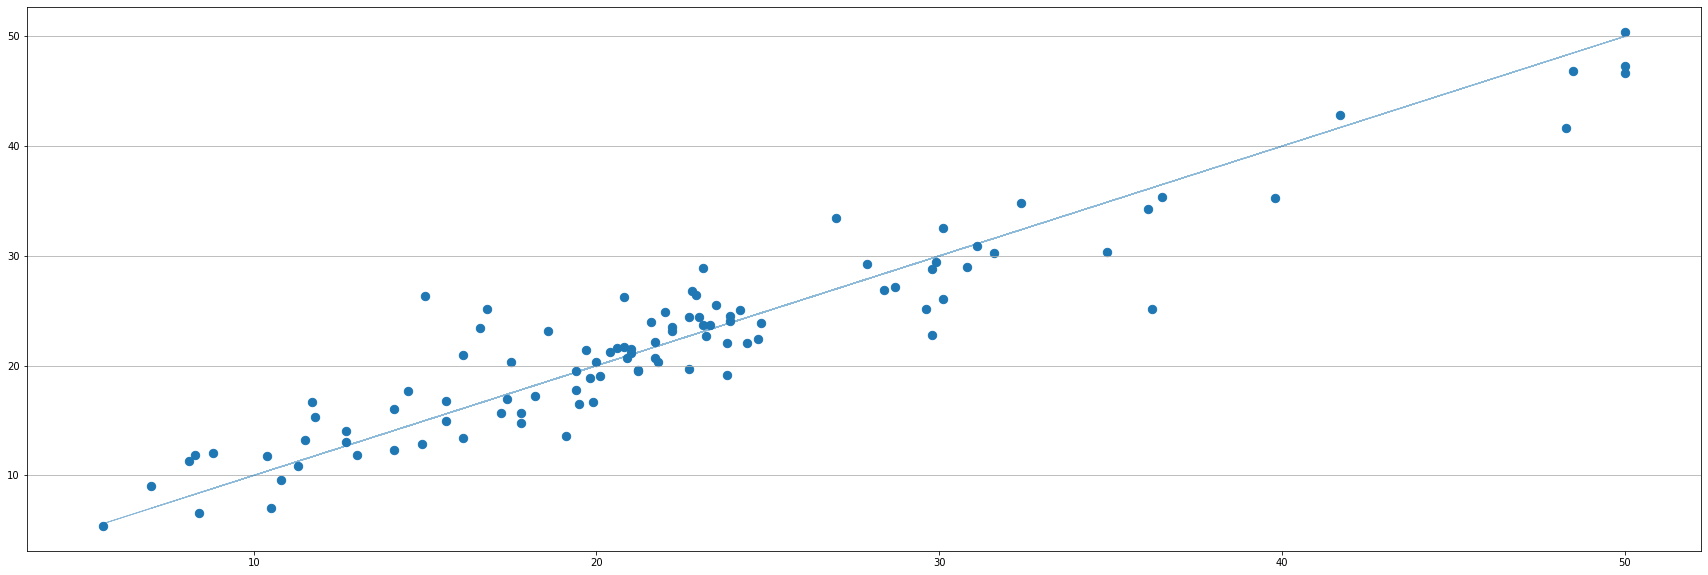

In [562]:
plt.plot(y_test,y_test,lw=0.9,alpha=0.5)
plt.scatter(y_test,boston_preds_7,s=70)
print(f'  MAE is {np.mean([np.abs(a-b) for a,b in zip(y_test,boston_preds_7)])}')

#### **LETS TUNE FOR DROPOUT AND ACTIVATION FUNCTION, TOO!**

In [9]:
def model_builder_2(hp):
    model = tf.keras.Sequential()
    hp_act_1 = hp.Choice('act1', values=['selu','relu','gelu','tanh'])
    hp_act_2 = hp.Choice('act2', values=['selu','relu','gelu','tanh'])
    hp_drop_1 = hp.Choice('drop1', values=[0.0, 0.1, 0.2])
    hp_drop_2 = hp.Choice('drop2', values=[0.0, 0.1, 0.2])
    hp_units_1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    hp_units_2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    model.add(tf.keras.layers.Dense(units=hp_units_1, activation=hp_act_1))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(hp_drop_1))
    model.add(tf.keras.layers.Dense(units=hp_units_2, activation=hp_act_2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(hp_drop_2))
    model.add(tf.keras.layers.Dense(1))

    r10 = 10**0.5
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, r10*1e-3, 1e-3, r10*1e-4, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss='mse',metrics=['mae','mse'])

    return model

In [10]:
tuner_2 = kt.Hyperband(model_builder_2,
                     objective='val_mse',
                     overwrite = True,
                     max_epochs=100,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt_new')

In [11]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)

In [12]:
# get the optimal hyperparameters
tuner_2.search(normed_train_data, y_train, epochs=80, validation_data=(normed_val_data,y_val), callbacks=[stop_early])

Trial 254 Complete [00h 00m 18s]
val_mse: 347.8382568359375

Best val_mse So Far: 5.636710166931152
Total elapsed time: 00h 13m 44s
INFO:tensorflow:Oracle triggered exit


In [13]:
best_hps_2 = tuner_2.get_best_hyperparameters(num_trials=1)[0]

print(f"""The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps_2.get('units1')} with {best_hps_2.get('act1')}, in the second layer it's {best_hps_2.get('units2')}
with {best_hps_2.get('act2')} and the optimal learning rate for the optimizer is {best_hps_2.get('learning_rate')}.
Dropouts should be {best_hps_2.get('drop1')},{best_hps_2.get('drop2')}""")

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 416 with relu, in the second layer it's 480
with gelu and the optimal learning rate for the optimizer is 0.001.
Dropouts should be 0.0,0.2


In [15]:
EPOCHS = 1000

boston_model_8 = tuner_2.hypermodel.build(best_hps_2)
boston_history_8 = boston_model_8.fit(normed_train_data, y_train, epochs=EPOCHS,
                                      validation_data=(normed_val_data, y_val), verbose=0, callbacks=[stop_early])
boston_model_8.save('boston_model_8')

2022-03-20 11:11:11.507053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-20 11:11:13.179610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-20 11:12:18.095474: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: boston_model_8/assets


In [16]:
boston_history_8 = pd.DataFrame(boston_history_8.history)

In [17]:
boston_history_8['loss_diffs'] = boston_history_8.apply(lambda x: np.abs(100*(x['val_loss']-x['loss'])/x['loss']),axis=1)
boston_history_8['mae_diffs'] = boston_history_8.apply(lambda x: np.abs(100*(x['val_mae']-x['mae'])/x['mae']),axis=1)

In [18]:
boston_preds_8 = boston_model_8.predict(normed_test_data)

2022-03-20 11:12:18.494249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


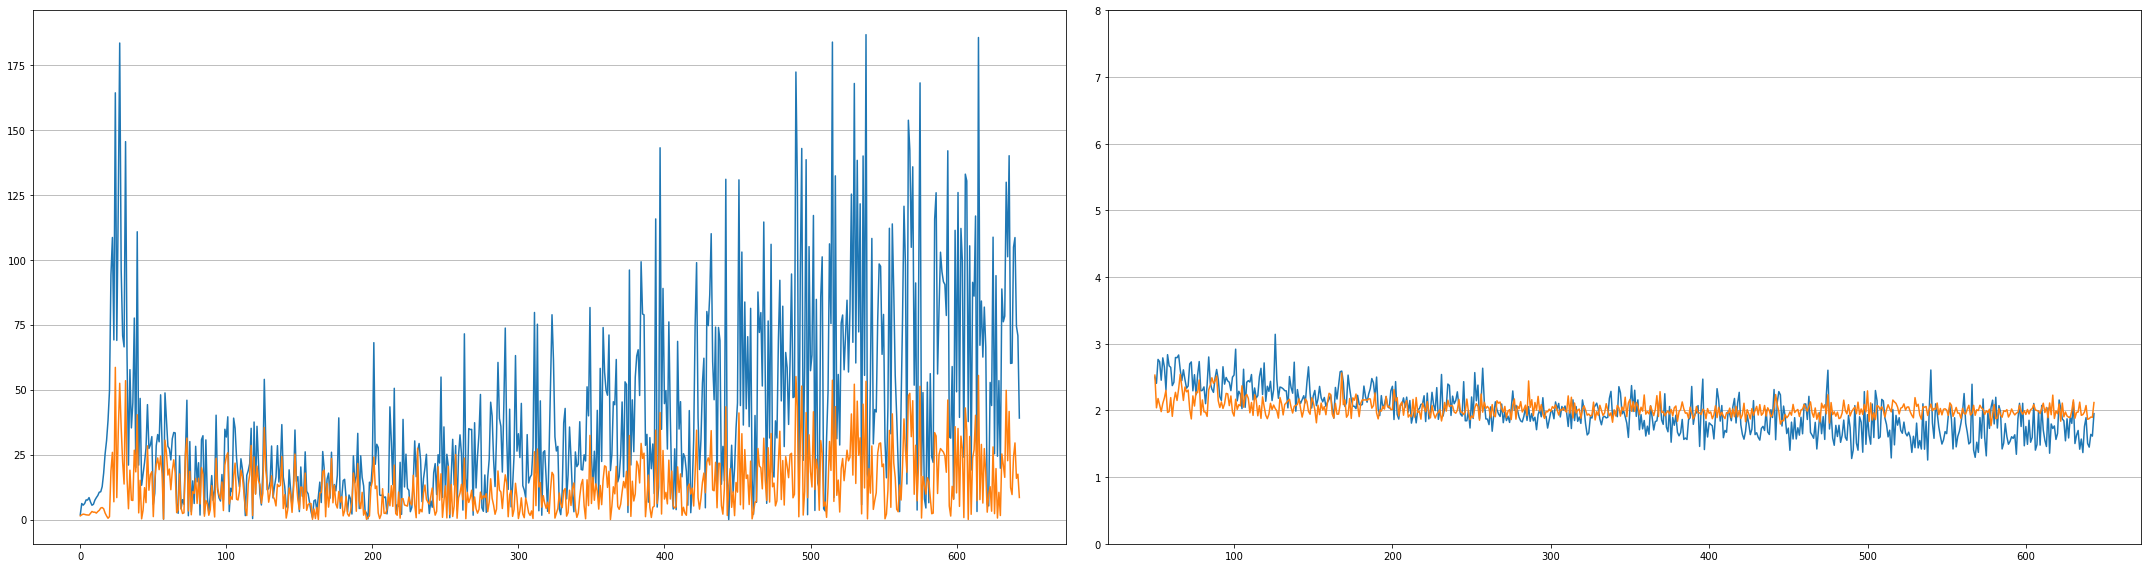

In [19]:
fig,axes = plt.subplots(1,2,figsize=(30,8))
fig.tight_layout()
axes[0].plot(boston_history_8[['loss_diffs','mae_diffs']]);
axes[1].set_ylim([0,8])
axes[1].plot(boston_history_8[['mae','val_mae']][50:]);

  MAE is 2.510627031326294


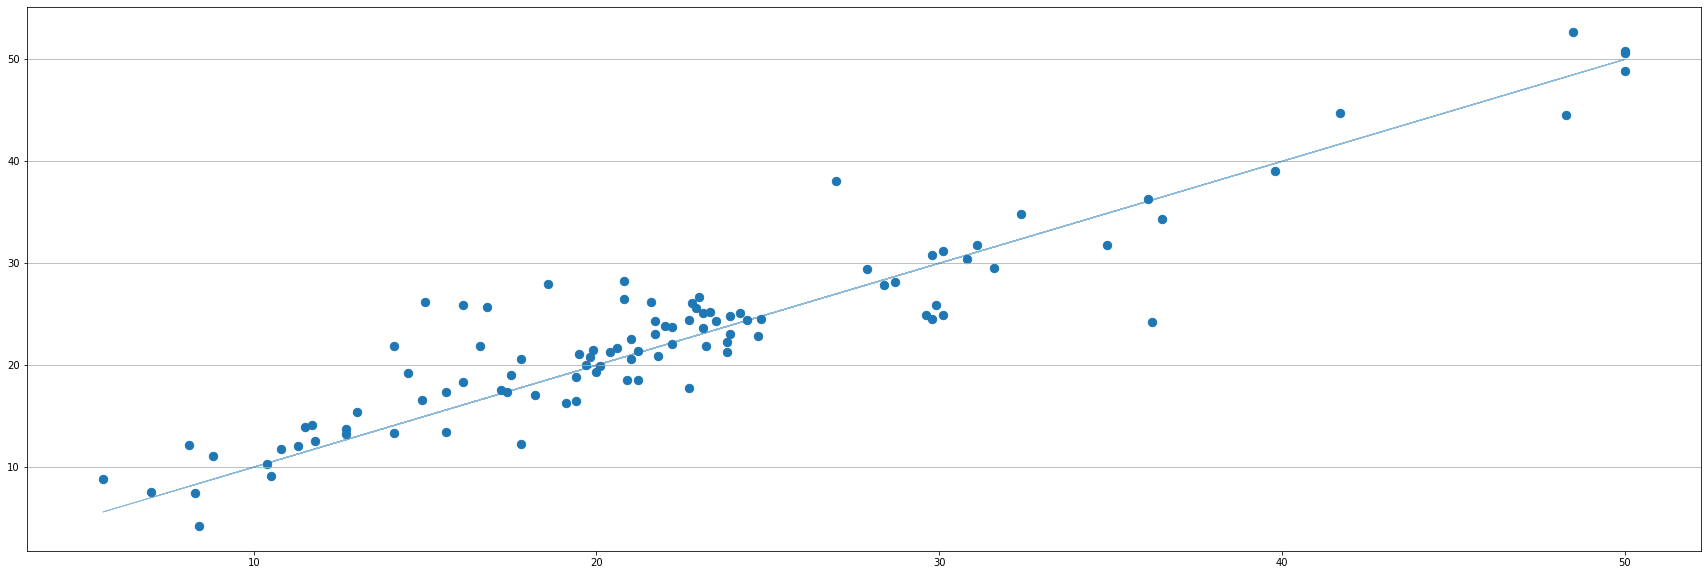

In [20]:
plt.plot(y_test,y_test,lw=0.9,alpha=0.5)
plt.scatter(y_test,boston_preds_8,s=70)
print(f'  MAE is {np.mean([np.abs(a-b) for a,b in zip(y_test,boston_preds_8)])}')

#### **CROSS-VALIDATING/BAGGING OUR TUNED MODEL**

Try this with different train/validation rotations (keeping test always locked!)

In [ ]:
EPOCHS = 1000
ROTATIONS = 200
boston_model_9 = tuner_2.hypermodel.build(best_hps_2)
boston_history_9 = []
for i in range(ROTATIONS):
    print(i)
    x = normed_train_data.append(normed_val_data).reset_index(drop=True)
    y = np.array(list(y_train)+list(y_val))
    xt, xv, yt, yv = train_test_split(x, y, test_size=0.25, random_state=np.random.randint(10000))
    boston_history_9.append(boston_model_9.fit(xt, yt, epochs=EPOCHS, validation_data=(xv, yv), verbose=0, callbacks=[stop_early]))
    hist = pd.DataFrame(boston_history_9[-1].history)
    hist['i'] = i
    boston_preds_9 = pd.DataFrame(boston_model_9.predict(normed_test_data),columns=[i])
    boston_history_9_all = hist if i==0 else boston_history_9_all.append(hist)
    boston_preds_9_all = boston_preds_9 if i==0 else pd.concat([boston_preds_9_all,boston_preds_9],axis=1)

In [594]:
boston_model_9.save('boston_model_9') #boston_model_9 = tf.keras.models.load_model('boston_model_9')
boston_history_9_all['loss_diffs'] = boston_history_9_all.apply(lambda x: np.abs(100*(x['val_loss']-x['loss'])/x['loss']),axis=1)
boston_history_9_all['mae_diffs'] = boston_history_9_all.apply(lambda x: np.abs(100*(x['val_mae']-x['mae'])/x['mae']),axis=1)
boston_history_9_all = boston_history_9_all.reset_index(drop=True)
boston_history_9_all.to_csv('boston_history_9_all.csv',index=False)
boston_preds_9_all.to_csv('boston_preds_9_all.csv',index=False)

INFO:tensorflow:Assets written to: boston_model_9/assets


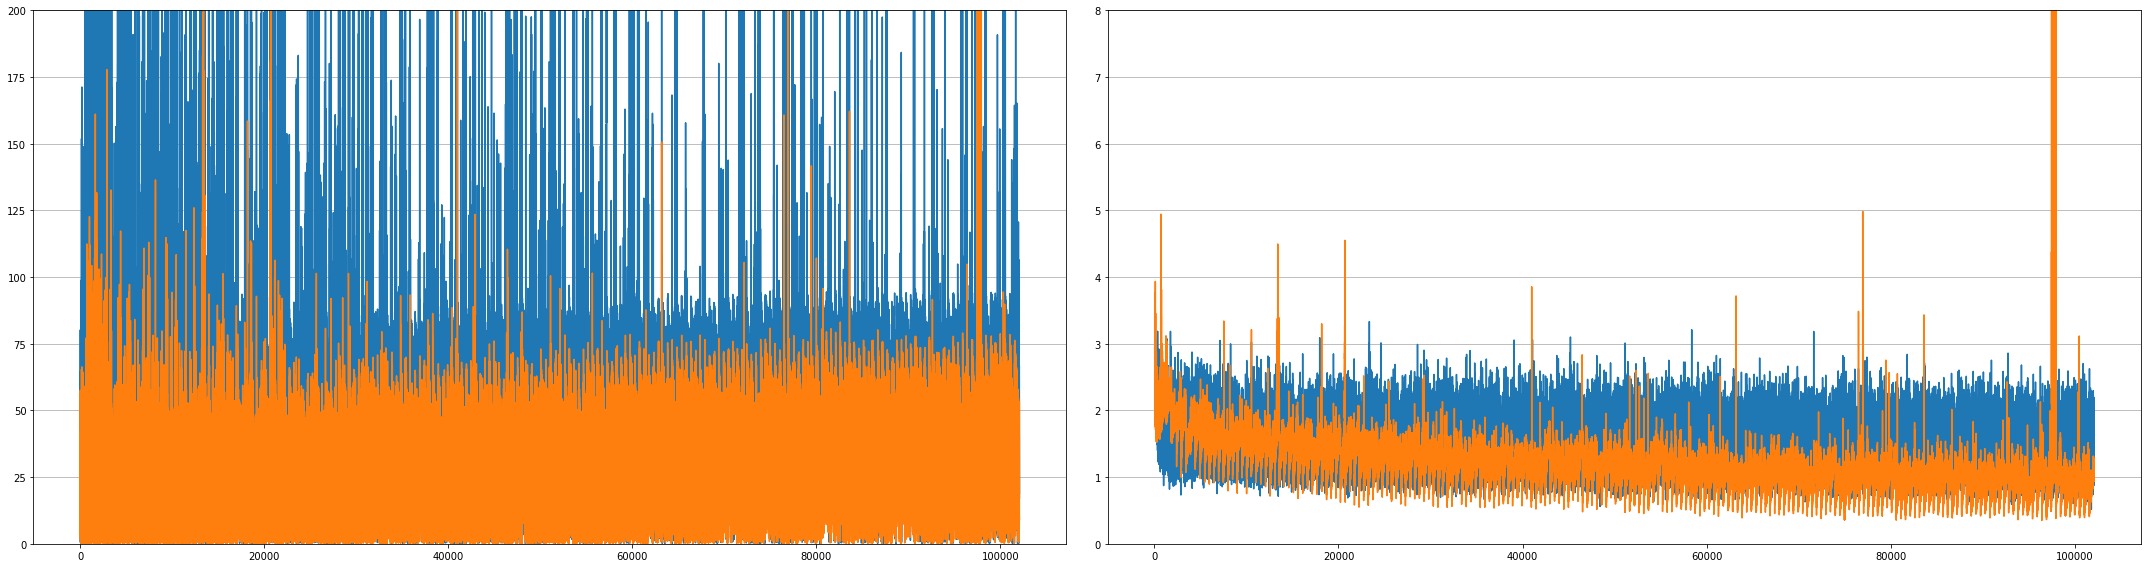

In [600]:
fig,axes = plt.subplots(1,2,figsize=(30,8))
fig.tight_layout()
axes[0].set_ylim([0,2e2])
axes[0].plot(boston_history_9_all[['loss_diffs','mae_diffs']]);
axes[1].set_ylim([0,8])
axes[1].plot(boston_history_9_all[['mae','val_mae']][50:]);

In [614]:
final_epochs = boston_history_9_all.drop_duplicates(subset=['i'],keep='last')
best_run = final_epochs[final_epochs['val_mae']==min(final_epochs['val_mae'])]['i']
int(best_run)

178

  MAE is 2.1213645261876724


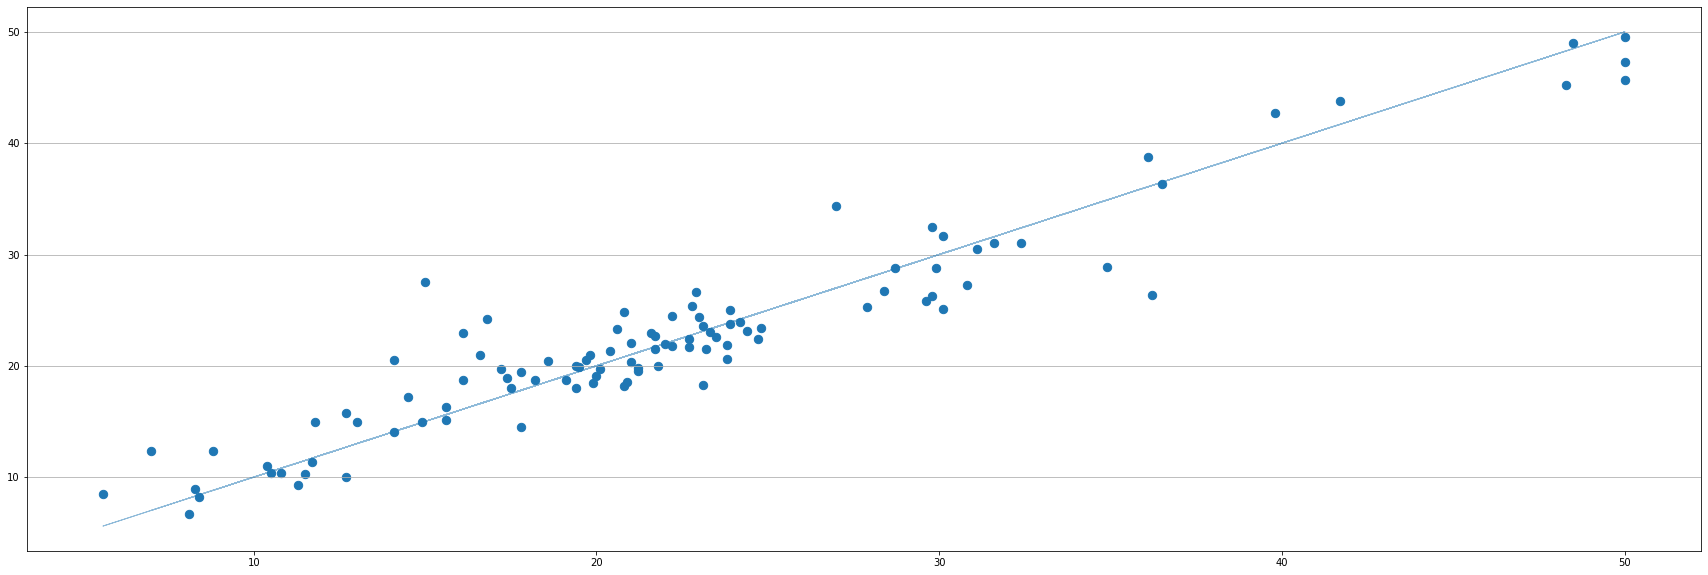

In [615]:
plt.plot(y_test,y_test,lw=0.9,alpha=0.5)
plt.scatter(y_test,boston_preds_9_all[int(best_run)],s=70)
print(f'  MAE is {np.mean([np.abs(a-b) for a,b in zip(y_test,boston_preds_9_all[int(best_run)])])}')

We are once again able to go close to our y = 2 threshold, but can't get below it.<br>

After around 3,500 compounded epochs, we begin to see a clear performance degradation, so we're going to want to work with the preds generated before this happens.  We can of course implement early stopping to prevent this, but sometimes its useful context to see it happen!

Looking at the state of the metrics after each set of epochs below, we can see the best was set 23, after 3,171 epochs.<br><br><br>

#### **CROSS-VALIDATING/BAGGING OUR TUNED MODEL - V2**

Here, we keep a locked validation set, and subset **only** the train.  This will prevent any overfitting the reduction of val_mae from using the validation set in our model

In [ ]:
EPOCHS = 1000
ROTATIONS = 500  #completed 10 so far
boston_model_10 = tuner_2.hypermodel.build(best_hps_2)
#boston_model_10 = tf.keras.models.load_model('boston_model_10')
boston_history_10 = []
#boston_history_10_all = pd.read_csv('boston_history_10_all.csv')
#boston_preds_10_all = pd.read_csv('boston_preds_10_all.csv')
for i in range(10,ROTATIONS):
    print(i)
    x = copy.deepcopy(normed_train_data) #.append(normed_val_data).reset_index(drop=True)
    x['MEDV'] = y_train
    xt = x.sample(frac=0.95).reset_index(drop=True)
    yt = xt.pop('MEDV')
    boston_history_10.append(boston_model_10.fit(xt,yt,epochs=EPOCHS,validation_data=(normed_test_data,y_val),verbose=0,callbacks=[stop_early]))
    hist = pd.DataFrame(boston_history_10[-1].history)
    hist['i'] = i
    boston_preds_10 = pd.DataFrame(boston_model_10.predict(normed_test_data),columns=[i])
    boston_history_10_all = hist if i==0 else boston_history_10_all.append(hist)
    boston_preds_10_all = boston_preds_10 if i==0 else pd.concat([boston_preds_10_all,boston_preds_10],axis=1)

In [92]:
boston_model_10.save('boston_model_10')
boston_history_10_all['loss_diffs'] = boston_history_10_all.apply(lambda x: np.abs(100*(x['val_loss']-x['loss'])/x['loss']),axis=1)
boston_history_10_all['mae_diffs'] = boston_history_10_all.apply(lambda x: np.abs(100*(x['val_mae']-x['mae'])/x['mae']),axis=1)
boston_history_10_all = boston_history_10_all.reset_index(drop=True)
boston_history_10_all.to_csv('boston_history_10_all.csv',index=False)
boston_preds_10_all.to_csv('boston_preds_10_all.csv',index=False)

INFO:tensorflow:Assets written to: boston_model_10/assets


In [93]:
last_epochs_10 = boston_history_10_all.drop_duplicates(subset=['i'],keep='last')
last_epochs_10[last_epochs_10['mae']==min(last_epochs_10['mae'])]

,loss,mae,mse,val_loss,val_mae,val_mse,i,loss_diffs,mae_diffs
4049,2.865895,1.348887,2.865895,160.470917,9.703443,160.470917,7,5499.33034,619.366492


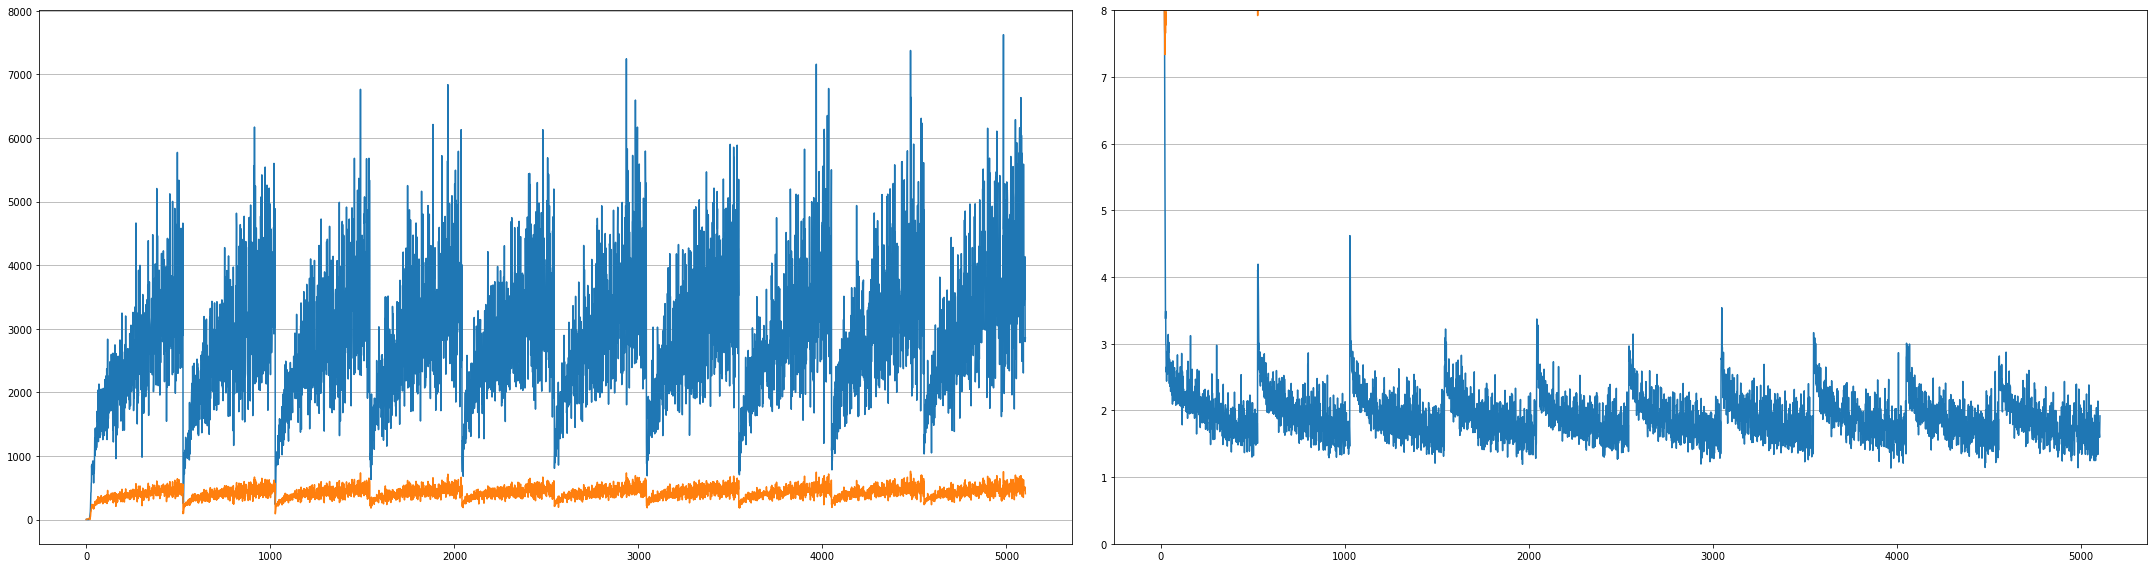

In [94]:
fig,axes = plt.subplots(1,2,figsize=(30,8))
fig.tight_layout()
#axes[0].set_ylim([0,2e2])
axes[0].plot(boston_history_10_all[['loss_diffs','mae_diffs']]);
axes[1].set_ylim([0,8])
axes[1].plot(boston_history_10_all[['mae','val_mae']][:]);

In [95]:
boston_preds_10_all #.columns[:30]

,0,1,2,3,4,5,6,7,8,9
0,18.453548,21.629072,17.907749,14.313560,12.766720,17.319424,18.105442,22.911211,14.229321,16.345913
1,21.851248,24.473295,20.162195,21.585541,20.826355,21.947060,21.382271,19.190695,21.799759,22.240484
2,28.164333,24.810419,25.584009,25.816359,27.745281,25.246332,24.518242,27.062586,26.316847,26.413576
3,22.074474,22.637232,21.183296,21.047083,21.745018,21.268362,20.791777,21.009642,20.309338,21.054466
4,19.647314,18.772654,19.157660,21.130806,16.927795,20.805574,19.971897,14.362607,20.145580,16.342848
...,...,...,...,...,...,...,...,...,...,...
97,22.849455,22.356550,24.681288,25.752649,21.103563,26.026737,24.566326,21.144707,25.682642,22.732546
98,24.666010,26.714943,27.594856,25.874268,26.122328,27.316563,24.272797,26.716942,23.922508,25.237833
99,23.476992,24.455915,21.645601,23.301218,20.912352,22.436062,23.853788,21.488976,22.480728,23.824900
100,24.134336,23.559813,25.287004,25.325941,25.190781,26.561842,24.589460,22.467741,22.766678,24.196745


  MAE is 2.7993714538275025


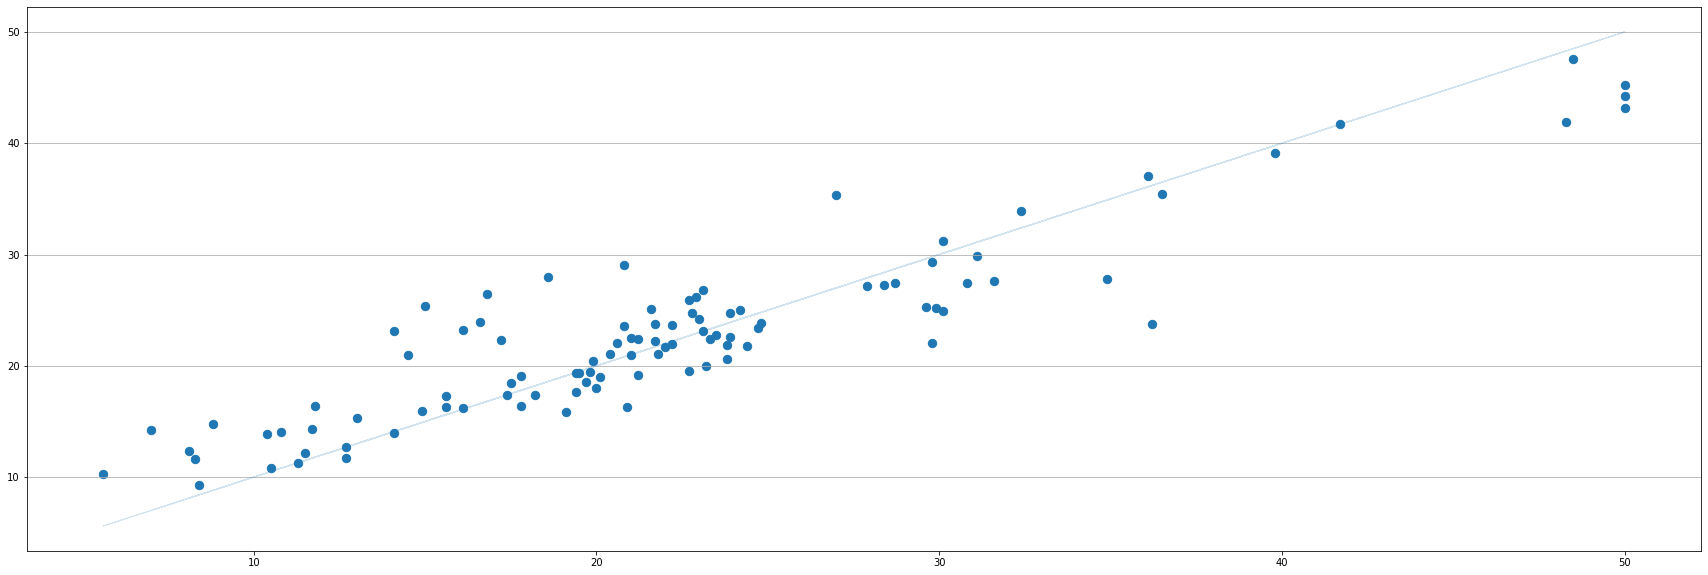

In [96]:
plt.plot(y_test,y_test,lw=0.9, alpha=0.2)
plt.scatter(y_test,boston_preds_10_all[max(boston_history_10_all['i'])-0],s=70)
print(f'  MAE is {np.mean([np.abs(a-b) for a,b in zip(y_test,boston_preds_10_all[max(boston_history_10_all["i"])-0])])}')

#### **WHAT HAPPENS IF WE BAG OVER A LOAD OF DIFFERENT MODELS, RATHER THAN INCREMENT OVER THE SAME ONE?**

(to complete)

In [ ]:
#boston_model_12

#### **LET'S EXPERIMENT WITH CUSTOM LOSS FUNCTIONS....**

What about the mean error to arbitrary powers, such as n^3, n^4 and higher?

In [4]:
def model_builder_3(hp):
    model = tf.keras.Sequential()

    def custom_loss_p4(y_true,y_pred):
        difference_p4 = tf.math.pow((y_true-y_pred),4)
        return tf.reduce_mean(difference_p4,axis=-1)
    
    hp_units_1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    hp_units_2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    model.add(tf.keras.layers.Dense(units=hp_units_1, activation='selu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(units=hp_units_2, activation='selu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(1))

    r10 = 10**0.5
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, r10*1e-3, 1e-3, r10*1e-4, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=custom_loss_p4,
                metrics=['mae','mse'])

    return model

In [5]:
tuner_3 = kt.Hyperband(model_builder_3,
     objective='val_mse',
     overwrite = True,
     max_epochs=100,
     factor=3,
     directory='kerastuner',
     project_name='model_builder_3')

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-19 19:06:04.790997: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-19 19:06:04.791104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)

In [8]:
# get the optimal hyperparameters
tuner_3.search(normed_train_data, y_train, epochs=80, validation_data=(normed_val_data,y_val), callbacks=[stop_early])

Trial 254 Complete [00h 00m 22s]
val_mse: 22.158716201782227

Best val_mse So Far: 7.786125183105469
Total elapsed time: 00h 14m 58s
INFO:tensorflow:Oracle triggered exit


In [11]:
best_hps_3 = tuner_3.get_best_hyperparameters(num_trials=1)[0]

print(f"""The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps_3.get('units1')}, in the second layer it's {best_hps_3.get('units2')} and the optimal learning
rate for the optimizer is {best_hps_3.get('learning_rate')}.""")

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 288, in the second layer it's 384 and the optimal learning
rate for the optimizer is 0.01.


In [13]:
EPOCHS = 1000

boston_model_12 = tuner_3.hypermodel.build(best_hps_3)
boston_history_12 = boston_model_12.fit(normed_train_data, y_train, epochs=EPOCHS,
                                      validation_data=(normed_val_data, y_val), verbose=0, callbacks=[stop_early])
boston_model_12.save('boston_model_12')

2022-03-19 19:25:33.501977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 19:25:34.476883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 19:27:26.577866: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: boston_model_12/assets


In [14]:
boston_history_12 = pd.DataFrame(boston_history_12.history)
boston_history_12['loss_diffs'] = boston_history_12.apply(lambda x: np.abs(100*(x['val_loss']-x['loss'])/x['loss']),axis=1)
boston_history_12['mae_diffs'] = boston_history_12.apply(lambda x: np.abs(100*(x['val_mae']-x['mae'])/x['mae']),axis=1)

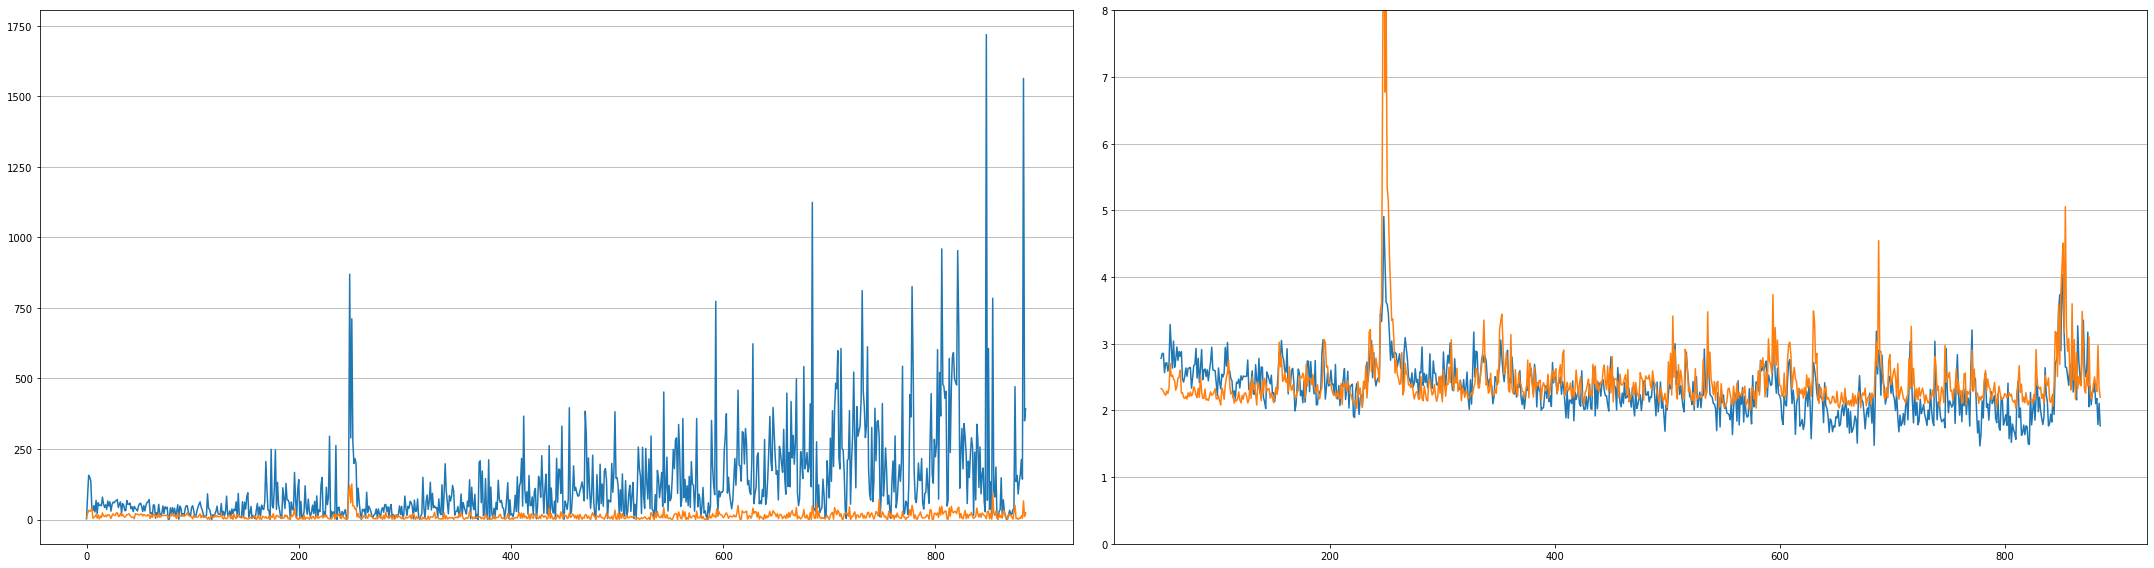

In [15]:
fig,axes = plt.subplots(1,2,figsize=(30,8))
fig.tight_layout()
axes[0].plot(boston_history_12[['loss_diffs','mae_diffs']]);
axes[1].set_ylim([0,8])
axes[1].plot(boston_history_12[['mae','val_mae']][50:]);

In [16]:
boston_preds_12 = boston_model_12.predict(normed_test_data)

2022-03-19 19:31:54.123244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  MAE is 2.500674247741699


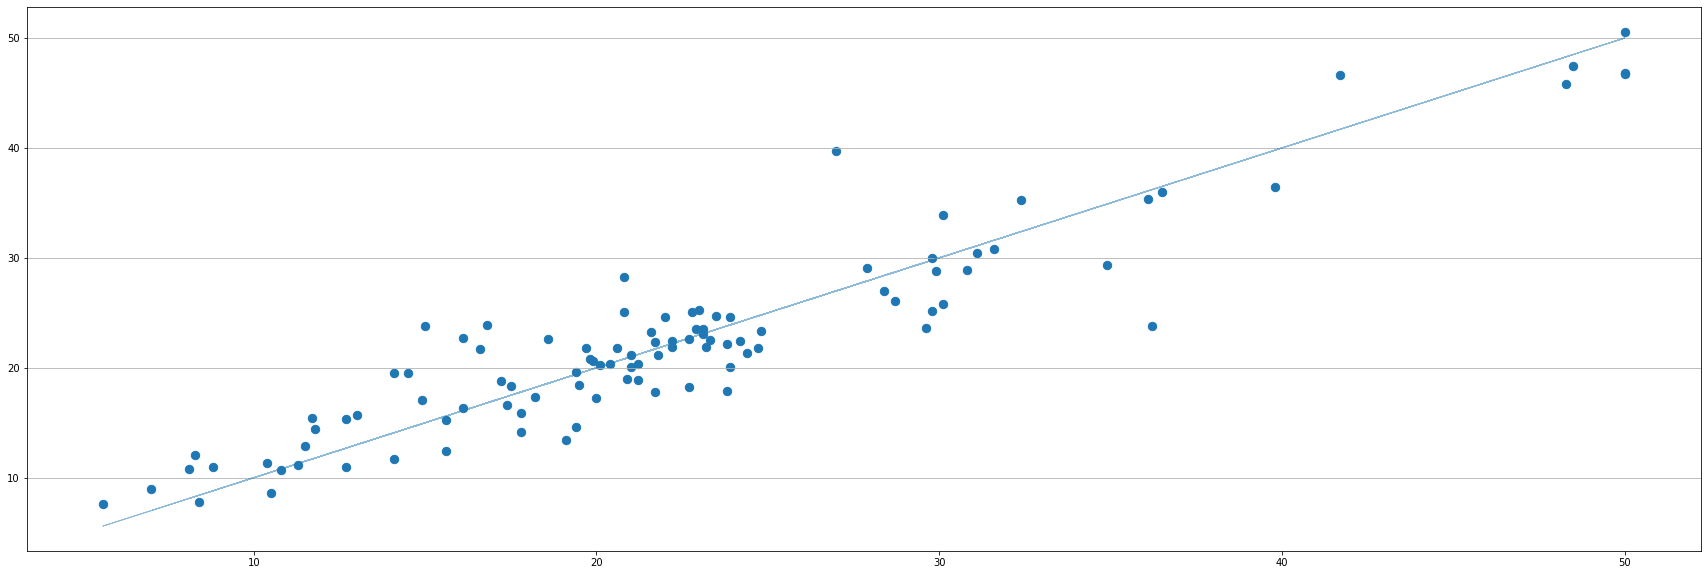

In [17]:
plt.plot(y_test,y_test,lw=0.9,alpha=0.5)
plt.scatter(y_test,boston_preds_12,s=70)
print(f'  MAE is {np.mean([np.abs(a-b) for a,b in zip(y_test,boston_preds_12)])}')

#### **CUSTOM LOSS FUNCTIONS V2 - TUNING ON MORE PARAMETERS**

In [18]:
def model_builder_4(hp):
    model = tf.keras.Sequential()

    def custom_loss_p4(y_true,y_pred):
        difference_p4 = tf.math.pow((y_true-y_pred),4)
        return tf.reduce_mean(difference_p4,axis=-1)

    hp_act_1 = hp.Choice('act1', values=['selu','relu','gelu','tanh'])
    hp_act_2 = hp.Choice('act2', values=['selu','relu','gelu','tanh'])
    hp_drop_1 = hp.Choice('drop1', values=[0.0, 0.1, 0.2])
    hp_drop_2 = hp.Choice('drop2', values=[0.0, 0.1, 0.2])
    hp_units_1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    hp_units_2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    model.add(tf.keras.layers.Dense(units=hp_units_1, activation=hp_act_1))
    model.add(tf.keras.layers.BatchNormalization())
    tf.keras.layers.Dropout(hp_drop_1),
    model.add(tf.keras.layers.Dense(units=hp_units_2, activation=hp_act_2))
    model.add(tf.keras.layers.BatchNormalization())
    tf.keras.layers.Dropout(hp_drop_2),
    model.add(tf.keras.layers.Dense(1))

    r10 = 10**0.5
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, r10*1e-3, 1e-3, r10*1e-4, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss=custom_loss_p4,metrics=['mae','mse'])

    return model

In [19]:
tuner_4 = kt.Hyperband(model_builder_4,
     objective='val_mse',
     overwrite = True,
     max_epochs=100,
     factor=3,
     directory='kerastuner',
     project_name='model_builder_4')

In [16]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, restore_best_weights=True)

In [21]:
tuner_4.search(normed_train_data, y_train, epochs=80, validation_data=(normed_val_data,y_val), callbacks=[stop_early])

Trial 254 Complete [00h 00m 16s]
val_mse: 7.342650890350342

Best val_mse So Far: 6.703728199005127
Total elapsed time: 00h 17m 54s
INFO:tensorflow:Oracle triggered exit


In [22]:
best_hps_4 = tuner_4.get_best_hyperparameters(num_trials=1)[0]

print(f"""The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps_4.get('units1')} with {best_hps_4.get('act1')}, in the second layer it's {best_hps_4.get('units2')}
with {best_hps_4.get('act2')} and the optimal learning rate for the optimizer is {best_hps_4.get('learning_rate')}.
Dropouts should be {best_hps_4.get('drop1')},{best_hps_4.get('drop2')}""")

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 192 with relu, in the second layer it's 160
with tanh and the optimal learning rate for the optimizer is 0.01.
Dropouts should be 0.2,0.0


In [24]:
EPOCHS = 1000

boston_model_13 = tuner_4.hypermodel.build(best_hps_4)
boston_history_13 = boston_model_13.fit(normed_train_data, y_train, epochs=EPOCHS,
                                      validation_data=(normed_val_data, y_val), verbose=0, callbacks=[stop_early])
boston_model_13.save('boston_model_13')

2022-03-19 19:55:35.891065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-19 19:55:37.733809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_13/assets


In [25]:
boston_history_13 = pd.DataFrame(boston_history_13.history)
boston_history_13['loss_diffs'] = boston_history_13.apply(lambda x: np.abs(100*(x['val_loss']-x['loss'])/x['loss']),axis=1)
boston_history_13['mae_diffs'] = boston_history_13.apply(lambda x: np.abs(100*(x['val_mae']-x['mae'])/x['mae']),axis=1)

In [26]:
boston_preds_13 = boston_model_13.predict(normed_test_data)

2022-03-19 19:57:08.012888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


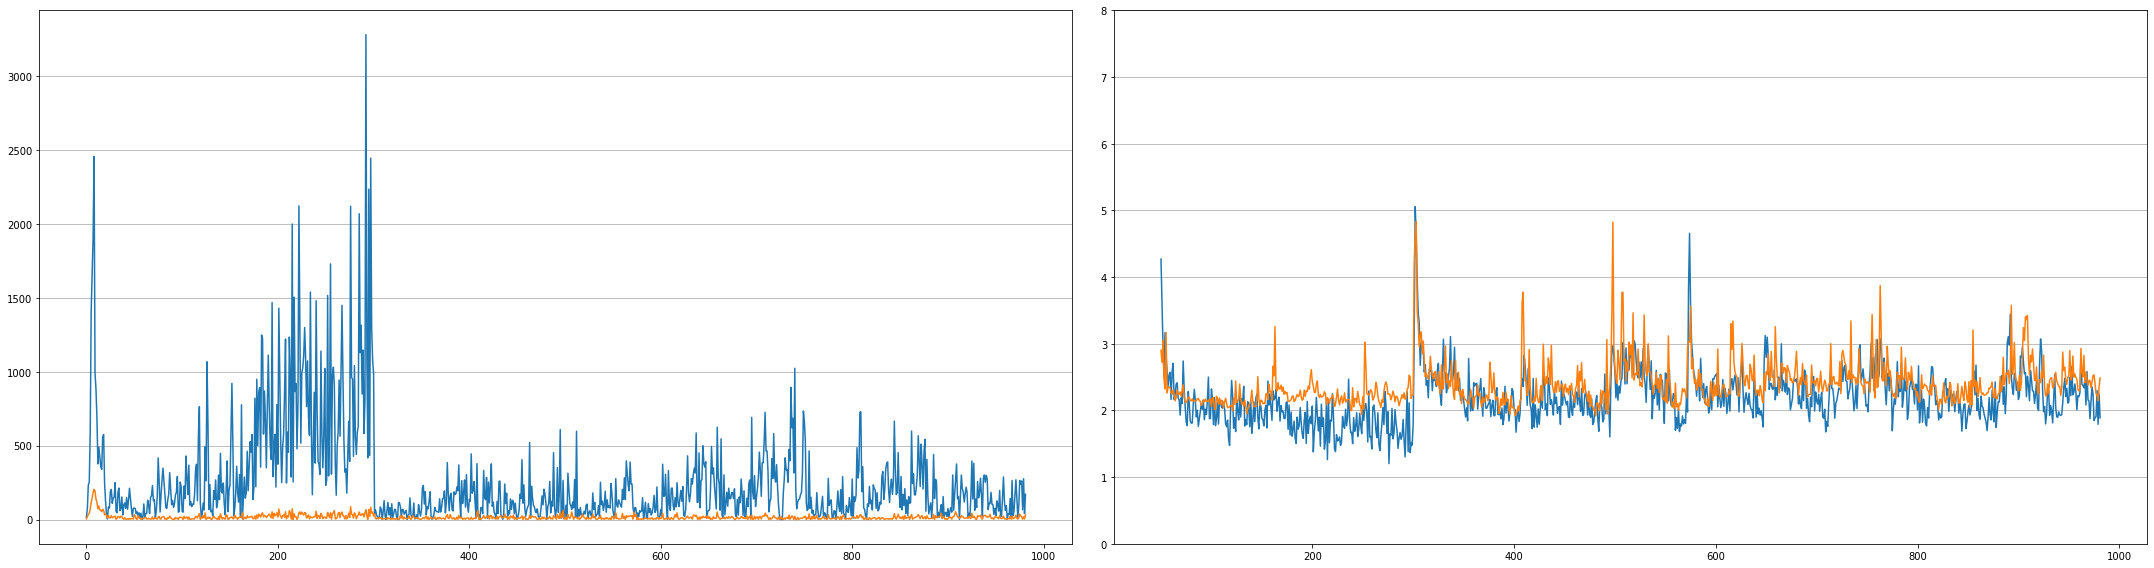

In [27]:
fig,axes = plt.subplots(1,2,figsize=(30,8))
fig.tight_layout()
axes[0].plot(boston_history_13[['loss_diffs','mae_diffs']]);
axes[1].set_ylim([0,8])
axes[1].plot(boston_history_13[['mae','val_mae']][50:]);

  MAE is 2.419511079788208


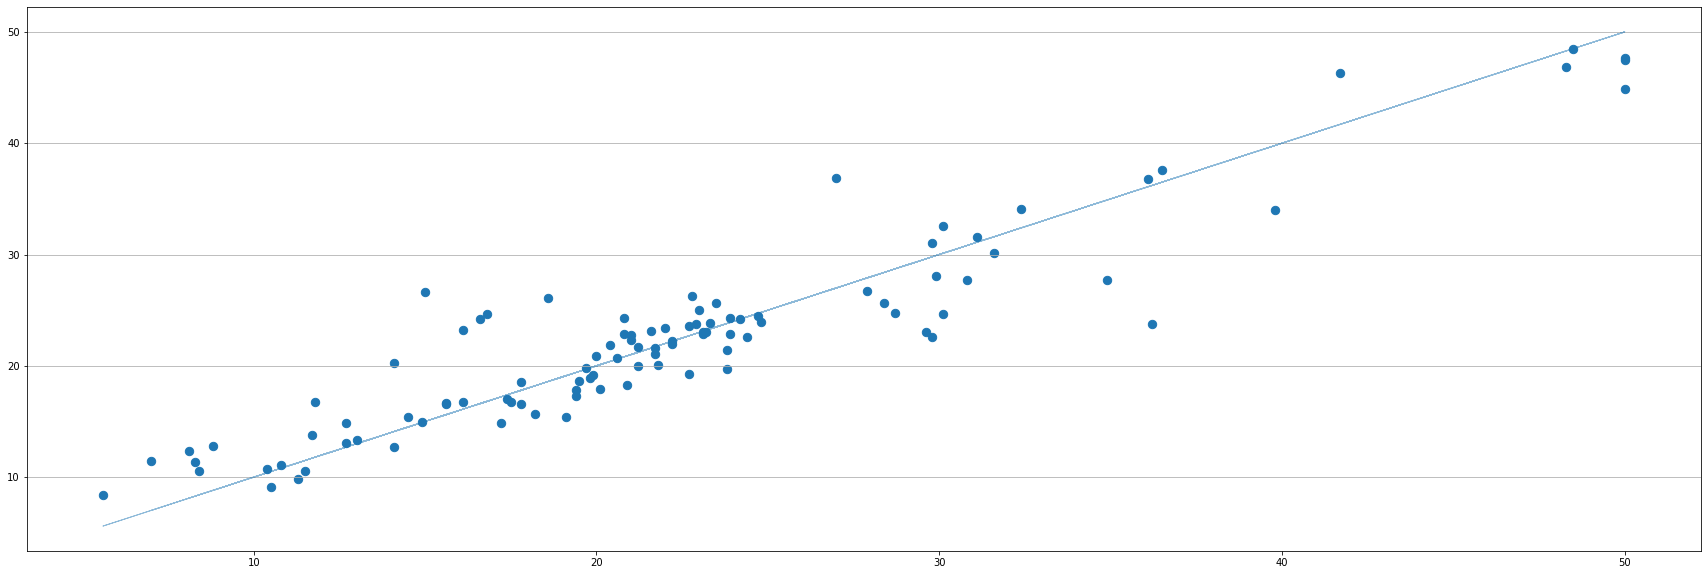

In [28]:
plt.plot(y_test,y_test,lw=0.9,alpha=0.5)
plt.scatter(y_test,boston_preds_13,s=70)
print(f'  MAE is {np.mean([np.abs(a-b) for a,b in zip(y_test,boston_preds_13)])}')

#### **TUNE INCLUDING THE CUSTOM LOSS FUNCTION**

In [5]:
def model_builder_5(hp):
    model = tf.keras.Sequential()

    hp_loss = hp.Choice('loss', values=[0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])
    def custom_loss(y_true,y_pred):
        difference = tf.math.pow(tf.abs(y_true-y_pred),hp_loss)
        return tf.reduce_mean(difference,axis=-1)
    
    hp_act_1 = hp.Choice('act1', values=['selu','relu','gelu','tanh'])
    hp_act_2 = hp.Choice('act2', values=['selu','relu','gelu','tanh'])
    hp_drop_1 = hp.Choice('drop1', values=[0.0, 0.1, 0.2])
    hp_drop_2 = hp.Choice('drop2', values=[0.0, 0.1, 0.2])
    hp_units_1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    hp_units_2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    model.add(tf.keras.layers.Dense(units=hp_units_1, activation=hp_act_1))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(hp_drop_1)),
    model.add(tf.keras.layers.Dense(units=hp_units_2, activation=hp_act_2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(hp_drop_2)),
    model.add(tf.keras.layers.Dense(1))

    r10 = 10**0.5
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, r10*1e-3, 1e-3, r10*1e-4, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),loss=custom_loss,metrics=['mae','mse'])

    return model

In [6]:
tuner_5 = kt.Hyperband(model_builder_5,
    objective='val_mse',
    overwrite = True,
    max_epochs=100,
    factor=3,
    directory='kerastuner',
    project_name='model_builder_5')

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-20 18:36:13.412420: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-20 18:36:13.412745: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
tuner_5.search(normed_train_data, y_train, epochs=100, validation_data=(normed_val_data,y_val))

Trial 254 Complete [00h 00m 13s]
val_mse: 7.167031288146973

Best val_mse So Far: 5.662458896636963
Total elapsed time: 00h 11m 14s
INFO:tensorflow:Oracle triggered exit


In [8]:
best_hps_5 = tuner_5.get_best_hyperparameters(num_trials=1)[0]

print(f"""The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps_5.get('units1')} with {best_hps_5.get('act1')}, in the second layer it's {best_hps_5.get('units2')}
with {best_hps_5.get('act2')} and the optimal learning rate for the optimizer is {best_hps_5.get('learning_rate')}.
Dropouts should be {best_hps_5.get('drop1')},{best_hps_5.get('drop2')}.  Loss power is {best_hps_5.get('loss')}""")

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 416 with relu, in the second layer it's 192
with gelu and the optimal learning rate for the optimizer is 0.01.
Dropouts should be 0.1,0.1.  Loss power is 1.0


In [10]:
model_tuner_5 = tuner_5.hypermodel.build(best_hps_5)

In [32]:
EPOCHS = 2000

boston_model_14 = tuner_5.hypermodel.build(best_hps_5)
boston_history_14 = boston_model_14.fit(normed_train_data, y_train, epochs=EPOCHS,
                                      validation_data=(normed_val_data, y_val), verbose=0, callbacks=[stop_early])
boston_model_14.save('boston_model_14')

2022-03-20 11:49:33.822227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-20 11:49:36.725117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_14/assets


In [33]:
boston_history_14 = pd.DataFrame(boston_history_14.history)
boston_history_14['loss_diffs'] = boston_history_14.apply(lambda x: np.abs(100*(x['val_loss']-x['loss'])/x['loss']),axis=1)
boston_history_14['mae_diffs'] = boston_history_14.apply(lambda x: np.abs(100*(x['val_mae']-x['mae'])/x['mae']),axis=1)

In [34]:
boston_preds_14 = boston_model_14.predict(normed_test_data)

2022-03-20 11:50:53.768247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


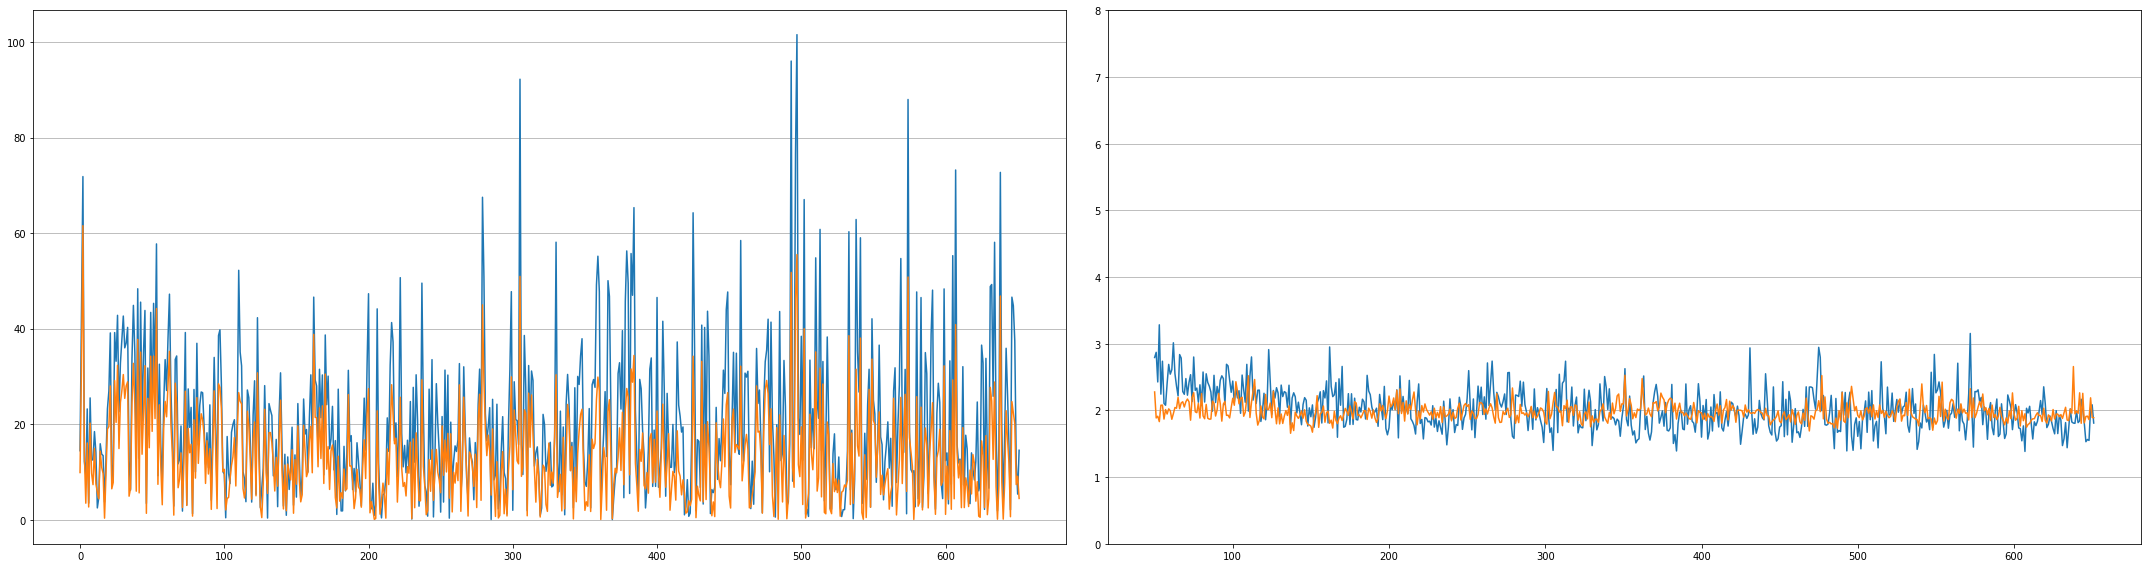

In [35]:
fig,axes = plt.subplots(1,2,figsize=(30,8))
fig.tight_layout()
axes[0].plot(boston_history_14[['loss_diffs','mae_diffs']]);
axes[1].set_ylim([0,8])
axes[1].plot(boston_history_14[['mae','val_mae']][50:]);

  MAE is 2.3748703002929688


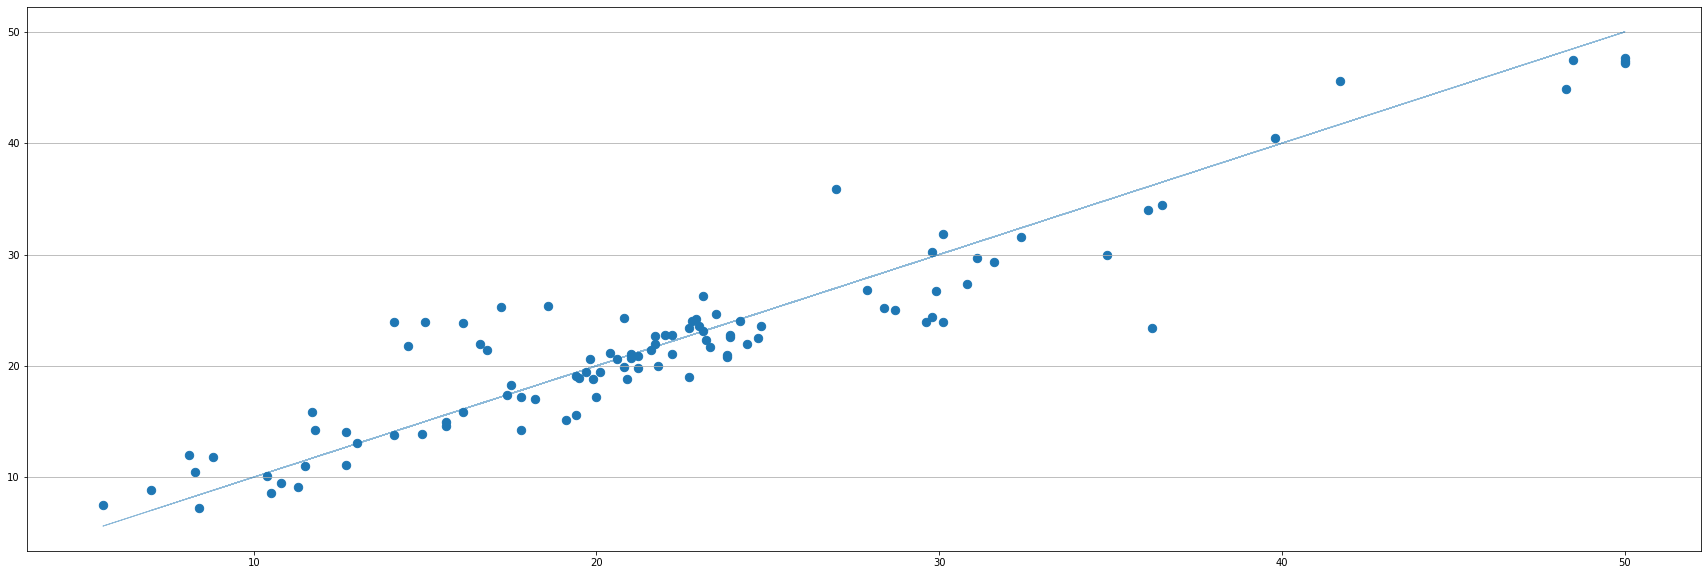

In [36]:
plt.plot(y_test,y_test,lw=0.9,alpha=0.5)
plt.scatter(y_test,boston_preds_14,s=70)
print(f'  MAE is {np.mean([np.abs(a-b) for a,b in zip(y_test,boston_preds_14)])}')

#### **TAKE OUR TUNED MODEL AND BAG IT AS MANY TIMES AS WE CAN!**

In [58]:
EPOCHS = 1000
ROTATIONS = 200
#boston_history_15_all = pd.read_csv('boston_history_15_all.csv')
#boston_preds_15_all = pd.read_csv('boston_preds_15_all.csv')
boston_history_15 = []
for i in range(176,ROTATIONS):
    tf.random.set_seed(np.random.randint(10000))
    boston_model_15 = tuner_5.hypermodel.build(best_hps_5)
    print(i)
    x = copy.deepcopy(normed_train_data)
    x['MEDV'] = y_train
    xt = x.sample(frac=0.95).reset_index(drop=True)
    yt = xt.pop('MEDV')
    boston_history_15.append(boston_model_15.fit(xt, yt, epochs=EPOCHS, validation_data=(normed_val_data,y_val), verbose=0, callbacks=[stop_early]))
    boston_model_15.save(f'boston_model_15_{i}')
    hist15 = pd.DataFrame(boston_history_15[-1].history)
    hist15['i'] = i
    boston_preds_15 = pd.DataFrame(boston_model_15.predict(normed_test_data),columns=[i])
    boston_history_15_all = hist15 if i==0 else boston_history_15_all.append(hist15)
    boston_preds_15_all = boston_preds_15 if i==0 else pd.concat([boston_preds_15_all,boston_preds_15],axis=1)

176


2022-03-21 01:56:41.742513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 01:56:45.230065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_176/assets


2022-03-21 01:58:17.451893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


177


2022-03-21 01:58:18.191585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 01:58:20.845728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_177/assets


2022-03-21 01:59:33.221834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


178


2022-03-21 01:59:33.805635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 01:59:36.192611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_178/assets


2022-03-21 02:00:45.108076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


179


2022-03-21 02:00:45.858222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:00:48.690414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_179/assets


2022-03-21 02:01:38.965909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


180


2022-03-21 02:01:39.585496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:01:42.787208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_180/assets


2022-03-21 02:02:47.968537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181


2022-03-21 02:02:48.722021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:02:51.835692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_181/assets


2022-03-21 02:04:17.184158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


182


2022-03-21 02:04:17.831604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:04:20.910403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_182/assets


2022-03-21 02:05:24.808205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


183


2022-03-21 02:05:25.596992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:05:28.634934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_183/assets


2022-03-21 02:06:54.817987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


184


2022-03-21 02:06:55.444793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:06:58.339397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_184/assets


2022-03-21 02:07:52.872294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


185


2022-03-21 02:07:53.463142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:07:56.390036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_185/assets


2022-03-21 02:08:55.417823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


186


2022-03-21 02:08:56.254557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:08:59.758521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_186/assets


2022-03-21 02:09:52.058330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


187


2022-03-21 02:09:52.757491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:09:56.129019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_187/assets


2022-03-21 02:10:56.771338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


188


2022-03-21 02:10:57.634770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:11:00.814134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_188/assets


2022-03-21 02:12:28.164915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


189


2022-03-21 02:12:28.881671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:12:32.063710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_189/assets


2022-03-21 02:13:29.287879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


190


2022-03-21 02:13:30.080026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:13:33.146259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_190/assets


2022-03-21 02:14:37.652909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


191


2022-03-21 02:14:38.381413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:14:41.962272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_191/assets


2022-03-21 02:16:10.303965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


192


2022-03-21 02:16:11.334850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:16:14.814367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_192/assets


2022-03-21 02:17:42.602802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


193


2022-03-21 02:17:43.569181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:17:46.986815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_193/assets


2022-03-21 02:18:48.669397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


194


2022-03-21 02:18:49.668673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:18:53.256416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_194/assets


2022-03-21 02:20:12.095905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


195


2022-03-21 02:20:13.003714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:20:17.062075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_195/assets


2022-03-21 02:21:40.386750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


196


2022-03-21 02:21:41.307587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:21:45.069941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_196/assets


2022-03-21 02:23:04.804643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


197


2022-03-21 02:23:05.443070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:23:08.668096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_197/assets


2022-03-21 02:24:12.212882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


198


2022-03-21 02:24:12.965546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:24:16.101834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_198/assets


2022-03-21 02:25:07.303007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


199


2022-03-21 02:25:08.021450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-21 02:25:11.298001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: boston_model_15_199/assets


2022-03-21 02:26:04.624943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [59]:
boston_history_15_all = boston_history_15_all.reset_index(drop=True)
boston_history_15_all.to_csv('boston_history_15_all.csv',index=False)
boston_preds_15_all.to_csv('boston_preds_15_all.csv',index=False)

In [60]:
boston_preds_15_all.columns = [str(c) for c in boston_preds_15_all.columns]

In [61]:
max(boston_history_15_all['i'])

199

In [62]:
boston_preds_15_all #.iloc[:,:110]

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,23.517197,23.011852,24.616095,25.547518,22.896955,24.501358,23.652603,23.559570,23.983315,24.115326,...,24.299894,25.154104,24.289520,22.887556,23.944342,24.566675,25.314848,21.833626,23.907787,23.444183
1,25.046869,23.062609,25.251432,26.153412,25.184704,24.634228,24.598112,23.803804,25.085421,24.201792,...,25.264439,23.054251,24.894457,24.317133,24.718000,23.608999,24.269468,23.656471,24.010073,25.019415
2,17.661301,16.681929,17.897398,17.397303,18.672703,17.749939,17.915651,17.042938,18.395672,17.244699,...,18.799980,16.583096,16.935993,17.536377,17.360214,17.260942,17.669710,17.442390,18.734081,17.259645
3,7.823178,12.148692,11.164986,11.391630,10.163982,9.255857,11.106283,9.650768,10.563087,11.568519,...,9.852690,10.501902,9.453785,9.424574,10.083922,9.772345,10.258796,10.100837,10.067398,11.281557
4,12.828965,11.216952,15.469155,16.377151,12.733177,15.610429,13.959761,14.298449,13.016650,16.537016,...,15.879056,14.700668,16.764904,14.212257,10.160262,15.257107,15.782222,12.591717,12.101363,14.798559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,11.273100,12.559614,13.616623,13.661648,12.595358,12.387580,12.893145,12.331842,12.098879,14.609998,...,13.833444,13.545964,13.846498,13.045722,12.660303,13.893425,13.222574,11.382381,11.984821,12.998138
98,19.576775,18.766068,19.354736,20.474199,20.175379,19.743271,19.974237,18.447281,19.826216,19.153326,...,19.884504,19.082239,18.897810,18.943956,19.098473,18.923464,19.512827,17.939915,19.253437,19.340158
99,21.950867,20.295214,21.258551,23.148584,22.458260,22.335735,21.148560,21.291004,21.498560,22.309271,...,22.944601,20.072638,22.407658,21.372768,22.489990,20.815588,22.370024,21.750124,22.036793,21.363352
100,27.502577,27.808767,29.030996,28.091284,26.865360,28.735382,27.662317,27.444143,27.374414,25.859987,...,27.628521,26.691641,26.741060,28.893764,27.195030,26.796324,27.473673,27.079689,28.568405,27.609621


  MAE is 2.004042984457577


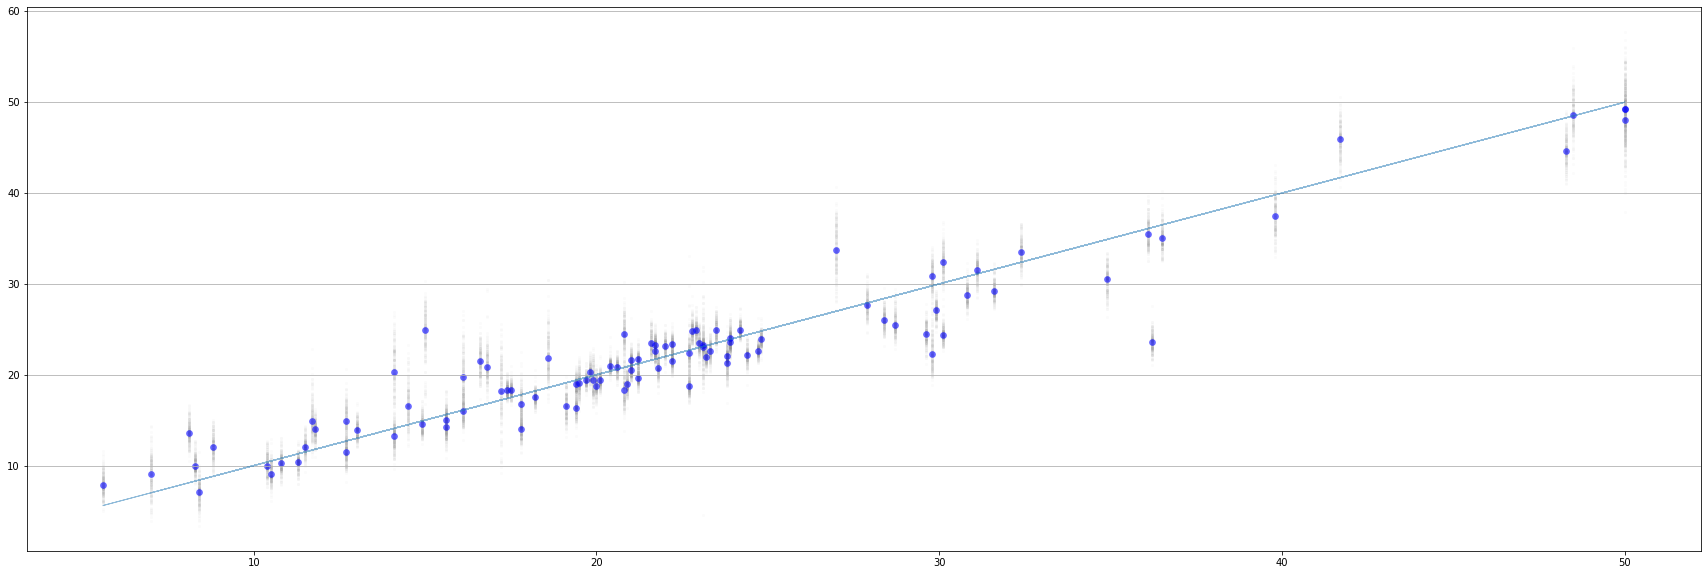

In [ ]:
plt.plot(y_test,y_test,lw=0.9,alpha=0.5)
for i in np.arange(max(boston_history_15_all['i'])):
    plt.scatter(y_test,boston_preds_15_all[str(i)], s=10, facecolor='grey', lw=0, alpha=0.03)
plt.scatter(y_test,boston_preds_15_all.median(axis=1),s=45,facecolor='blue', lw=0, alpha=0.6)
print(f'  MAE is {np.mean([np.abs(a-b) for a,b in zip(y_test,boston_preds_15_all.median(axis=1))])}')

#### **RANDOM FOREST**

In [7]:
normed_train_data = pd.read_csv('data/normed_train_data.csv')
normed_val_data = pd.read_csv('data/normed_val_data.csv')
normed_test_data = pd.read_csv('data/normed_test_data.csv')
y_train = pd.read_csv('data/y_train.csv')
y_val = pd.read_csv('data/y_val.csv')
y_test = pd.read_csv('data/y_test.csv')

In [19]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.datasets import make_classification

In [20]:
#X, y = make_classification(n_samples=10000, n_features=4, n_informative=2, n_redundant=0, random_state=0, shuffle=False)

In [47]:
for a in range(500):
    rf1 = RandomForestRegressor(max_depth=100, random_state=np.random.randint(10000))
    rf1.fit(np.array(normed_train_data),np.array(y_train))
    preds = pd.DataFrame(rf1.predict(normed_test_data))
    preds_all = preds if a==0 else pd.concat([preds_all,preds],axis=1)
    rf2 = RandomForestRegressor(max_depth=100, random_state=np.random.randint(10000))
    rf2.fit(np.array(normed_val_data),np.array(y_val))
    preds = pd.DataFrame(rf2.predict(normed_test_data))
    preds_all = pd.concat([preds_all,preds],axis=1)

In [48]:
preds_all.columns = [int(a) for a in range(1000)]

  MAE is 2.1808431372549015


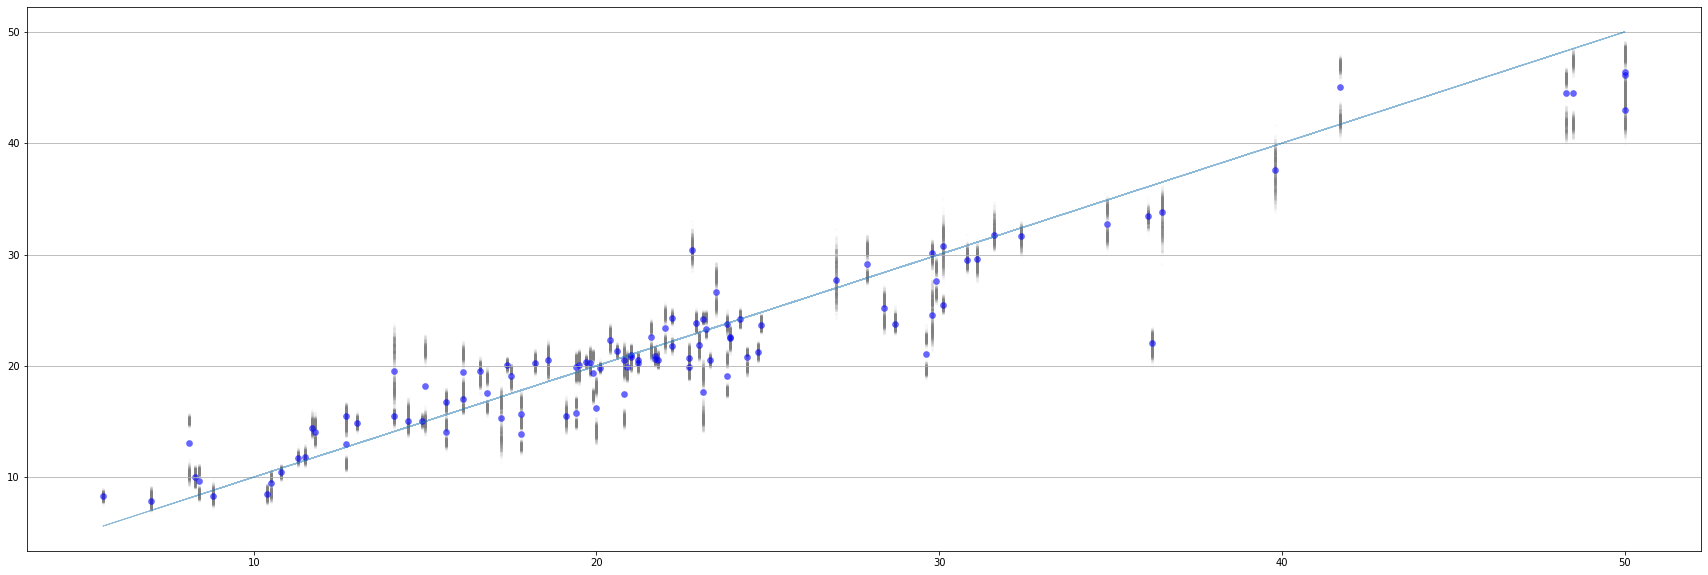

In [49]:
plt.plot(y_test,y_test,lw=0.9,alpha=0.5)
for i in preds_all.columns:
    plt.scatter(y_test,preds_all[i], s=10, facecolor='grey', lw=0, alpha=0.03)
plt.scatter(y_test,preds_all.median(axis=1),s=45,facecolor='blue', lw=0, alpha=0.6)
print(f'  MAE is {np.mean([np.abs(a-b) for a,b in zip(np.array(y_test),preds_all.median(axis=1))])}')